In [9]:
import pandas as pd
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, precision_score
from itertools import combinations
from xgboost import XGBClassifier
import datetime
import pickle
import base64
from random import sample

In [10]:
def get_historical_data(symbol, interval, days):
    # Calculate the start time (40 days ago from now)
    start_time = datetime.datetime.now() - datetime.timedelta(days=days)
    start_time_str = start_time.strftime('%Y-%m-%d %H:%M:%S')

    # Fetch historical klines data
    client = Client()
    klines = client.get_historical_klines(symbol, interval, start_time_str)
    
    # Convert to DataFrame
    klines_df = pd.DataFrame(klines)
    
    # Assign column names
    klines_df.columns = [
        'Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 
        'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 
        'Taker buy quote asset volume', 'Ignore'
    ]
    
    # Data is supplied in UTC+0
    klines_df['Open time'] = pd.to_datetime(klines_df['Open time']/1000, unit = 's', utc=True).dt.tz_convert(tz='Europe/Berlin')
    klines_df['Close time'] = pd.to_datetime(klines_df['Close time']/1000, unit = 's', utc=True).dt.tz_convert(tz='Europe/Berlin')
    
    numeric_columns = [
        'Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
        'Taker buy base asset volume', 'Taker buy quote asset volume'
    ]
    klines_df[numeric_columns] = klines_df[numeric_columns].apply(pd.to_numeric, axis=1)
    return klines_df

def make_signals(pred: pd.Series, holding_period: int):
    np_pred = pred
    for i in reversed(range(len(np_pred))):
        if np_pred[i] == 1:
            np_pred[i:i+holding_period] = 1
    np_pred = np_pred
    return np_pred 

# De-serialize an object from a plain text
def txt_to_obj(txt):
    base64_bytes = txt.encode('ascii')
    message_bytes = base64.b64decode(base64_bytes)
    obj = pickle.loads(message_bytes)
    return obj

def bot(data: pd.DataFrame):
    symbol = 'BTCEUR'
    days = 1000
    SIGNAL_TH = 0.55
    HOLDING_PERIOD = 24
    FEATURES = ['OBV', 'EMA_24_Sig', 'SMA_168_Sig']
    MODEL = ""
    
    # TODO: while true, sleep
    try:
        # Download Dataset
        bitcoin_data_hour = get_historical_data(symbol, Client.KLINE_INTERVAL_1HOUR, days)
        bitcoin_data_hour["pct"] = bitcoin_data_hour["Close"].pct_change().shift(-1) 
        bitcoin_data_hour.dropna(inplace=True)
        df_hour = bitcoin_data_hour
        
        # Make Indicators
        dt_indicators = []
        OBV_berechnen(df_hour)
        #MACD_berechnen(df_hour)
        dt_indicators.extend([f'OBV', f'MACD'])
        for i in [24, 24*7, 24*30]:#[5, 10, 20, 50, 100, 500, 1000]:
            SMA_berechnen(df_hour, i)
            #RSI_berechnen(df_hour, i)
            EMA_berechnen(df_hour, i)
            #HMA_berechnen(df_hour, i)
            #Momentum_berechnen(df_hour, i)
            #Stochastic_RSI_berechnen(df_hour, i)
        dt_indicators.extend([f"RSI_{i}", f"SMA_{i}_Sig", f"EMA_{i}_Sig", f"HMA_{i}_Sig", f"Momentum_{i}", f"StochRSI_{i}"])
    
        data = df_hour.reset_index(drop=True)
        X_test = data[FEATURES]
    
        # Load Model
        clf = txt_to_obj(MODEL) # TODO: Load model
        
        # Predict
        y_pred_proba = clf.predict_proba(X_test)
        y_pred = (y_pred_proba[:, 1] > SIGNAL_TH).astype(int)
        y_pred = make_signals(y_pred, HOLDING_PERIOD)
        prediction = y_pred[-1] #TODO:L  Order?
        if prediction == 1:
            return "BTC"
        else:
            return "EUR"
    except Exception as e:
        # Error handling in case API call doesn't work
        print(e)
        pass 
    
    print("SCHLECHT!")
    return "EUR" # or # "BTC"

In [4]:
bot(None)

KeyboardInterrupt: 

In [11]:
TRANSACTION_COSTS = 0.0005
# Start investment is EURO!

In [12]:
# Fetch Bitcoin prices at 5-minute intervals for the last 40 days
symbol = 'BTCEUR'
days = 10000

bitcoin_data_hour = get_historical_data(symbol, Client.KLINE_INTERVAL_1HOUR, days)
#bitcoin_data_5minute = get_historical_data(symbol, Client.KLINE_INTERVAL_5MINUTE, days)

In [13]:
bitcoin_data_hour["Open time"]

0       2020-01-03 09:00:00+01:00
1       2020-01-03 10:00:00+01:00
2       2020-01-03 11:00:00+01:00
3       2020-01-03 12:00:00+01:00
4       2020-01-03 13:00:00+01:00
                   ...           
40647   2024-08-24 09:00:00+02:00
40648   2024-08-24 10:00:00+02:00
40649   2024-08-24 11:00:00+02:00
40650   2024-08-24 12:00:00+02:00
40651   2024-08-24 13:00:00+02:00
Name: Open time, Length: 40652, dtype: datetime64[ns, Europe/Berlin]

In [14]:
bitcoin_data_hour.shape

(40652, 12)

In [15]:
bitcoin_data_hour["pct"] = bitcoin_data_hour["Close"].pct_change().shift(-1)    #time shift ist WICHTIG! einer der häufigsten Fehler, wenn er vergessen wird
#bitcoin_data_5minute["pct"] = bitcoin_data_5minute["Close"].pct_change().shift(-1)

In [16]:
bitcoin_data_hour.dropna(inplace=True)
#bitcoin_data_5minute.dropna(inplace=True)

df_hour = bitcoin_data_hour
#df_5minute = bitcoin_data_5minute


In [17]:
def sharpe_ratio(s):
    s = np.log(1+s)
    sharpe = s.mean() / s.std()
    print(f"mean={s.mean():.6f}, std={s.std():.6f}")
    return sharpe

In [18]:
#Funktion um zu zählen wie häufig ein buy Signal hinter einander auftritt
def count_consecutive_ones(data: pd.DataFrame, signal_col: str):
    new_column_name = signal_col + "_count"
    
    count = 0
    counts = []
    
    for value in data[signal_col]:
        if value == 1:
            count += 1
        else:
            count = 0
        counts.append(count)
    
    data[new_column_name] = counts

### Indikatoren und Indexe berechnen

In [26]:
def SMA_berechnen(data:pd.DataFrame, intervall:int):
    spalten_name = "SMA_"+str(intervall)
    data[spalten_name] = data["Close"].rolling(intervall).mean()
    spalten_name_sig = "SMA_"+str(intervall)+"_Sig"
    data[spalten_name_sig] = (data["Close"]>data[spalten_name]).astype(int)
    print(data[spalten_name_sig].mean())
    count_consecutive_ones(data, spalten_name_sig)
    
def RSI_berechnen(data:pd.DataFrame, intervall:int):

    spalten_name = "RSI_"+str(intervall)

    # Bestimme die Preisänderung zum jeweiligen Zeitpunkt t-1
    delta = np.log(data["Close"]).diff()

    # Get rid of the first row, which has NaN values
    delta = delta[1:]

    # Calculate the gains and losses
    up = delta.where(delta > 0, 0)
    down = -delta.where(delta < 0, 0)

    # Calculate the rolling average of the gains and losses
    #window_size = 14 #als default
    avg_gain = up.rolling(intervall).mean()
    avg_loss = down.rolling(intervall).mean()

    # Calculate the relative strength
    rs = avg_gain / avg_loss

    # Calculate the RSI
    data[spalten_name] = 100 - (100 / (1 + rs))
    
def EMA_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "EMA_" + str(intervall)
    data[spalten_name] = data["Close"].ewm(span=intervall, adjust=False).mean()
    spalten_name_sig = "EMA_"+str(intervall)+"_Sig"
    data[spalten_name_sig] = (data["Close"]>data[spalten_name]).astype(int)
    count_consecutive_ones(data, spalten_name_sig)

def HMA_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "HMA_" + str(intervall)
    half_length = int(intervall / 2)
    sqrt_length = int(np.sqrt(intervall))

    wma_half = data["Close"].rolling(window=half_length).mean()
    wma_full = data["Close"].rolling(window=intervall).mean()

    raw_hma = 2 * wma_half - wma_full
    data[spalten_name] = raw_hma.rolling(window=sqrt_length).mean()
    
    spalten_name_sig = "HMA_"+str(intervall)+"_Sig"
    data[spalten_name_sig] = (data["Close"]>data[spalten_name]).astype(int)
    count_consecutive_ones(data, spalten_name_sig)

def MACD_berechnen(data: pd.DataFrame, fast_period: int = 12, slow_period: int = 26, signal_period: int = 9):
    data["MACD"] = data["Close"].ewm(span=fast_period, adjust=False).mean() - data["Close"].ewm(span=slow_period, adjust=False).mean()
    data["MACD_Signal"] = data["MACD"].ewm(span=signal_period, adjust=False).mean()

def Momentum_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "Momentum_" + str(intervall)
    data[spalten_name] = data["Close"].pct_change(intervall)

def Stochastic_RSI_berechnen(data: pd.DataFrame, intervall: int):
    spalten_name = "StochRSI_" + str(intervall)

    delta = np.log(data["Close"]).diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=intervall).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=intervall).mean()

    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))

    min_RSI = RSI.rolling(window=intervall).min()
    max_RSI = RSI.rolling(window=intervall).max()

    data[spalten_name] = (RSI - min_RSI) / (max_RSI - min_RSI)

In [27]:
dt_indicators = []
MACD_berechnen(df_hour)
dt_indicators.extend([f'MACD'])
for i in [24, 24*7, 24*30]:#[5, 10, 20, 50, 100, 500, 1000]:
    SMA_berechnen(df_hour, i)
    RSI_berechnen(df_hour, i)
    EMA_berechnen(df_hour, i)
    HMA_berechnen(df_hour, i)
    Momentum_berechnen(df_hour, i)
    Stochastic_RSI_berechnen(df_hour, i)
    dt_indicators.extend([f"RSI_{i}", f"SMA_{i}_Sig", f"EMA_{i}_Sig", f"HMA_{i}_Sig", f"Momentum_{i}", f"StochRSI_{i}"])
    

0.5253007306093331
0.5368625618065976
0.5350667880248948


<BarContainer object of 24 artists>

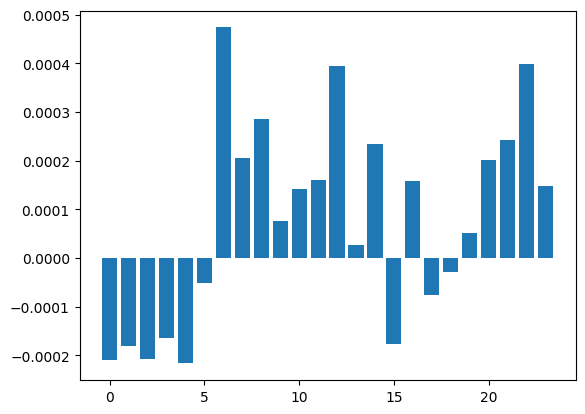

In [28]:
df_hour["Hour"] = df_hour["Open time"].dt.hour
tmp = df_hour.groupby("Hour")["pct"].mean()
plt.bar(x=tmp.index, height=tmp)

In [29]:
# Calendar Effects:
df_hour["Is_AfterHour"] = df_hour["Open time"].dt.hour >= 22
df_hour["Is_Monday"] = df_hour["Open time"].dt.day_of_week == 0
dt_indicators.extend([f'Is_AfterHour', f'Is_Monday'])

In [30]:
#berechnet performance für das gewollte Zeitfenster
def create_labels(df: pd.DataFrame, window: int):
    data = df.copy()
    data["future_return"] = data["Close"].shift(-window) / data["Close"] - 1
    data["label"] = (data["future_return"] > TRANSACTION_COSTS*2).astype(int)
    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

In [54]:
from sklearn import tree
def train_model(data: pd.DataFrame, features: list, target: str, param_grid, estimator):
    # Indizes zurücksetzen, um Probleme mit der Indizierung zu vermeiden
    data = data.reset_index(drop=True)
    
    # Aufteilen der Daten in Trainings- und Testdaten
    train_size = int(len(data) * 0.8)
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    X_train = train_data[features].dropna()
    X_test = test_data[features]
    y_train = train_data[target]
    
    # Definiere den Precision-Scorer
    precision_scorer = make_scorer(precision_score, pos_label=1)
    
    # Initialisiere den GridSearchCV
    grid_search = GridSearchCV(estimator=estimator,
                               param_grid=param_grid,
                                cv=4,  # Anzahl der Cross-Validation-Folds
                                scoring=precision_scorer,  # Bewertungskriterium
                                n_jobs=-1,  # Nutze alle verfügbaren CPU-Kerne
                                verbose=2)  # Ausgabe von Fortschrittsinformationen

     # Führe GridSearch aus
    grid_search.fit(X_train, y_train)
    
    # Ausgabe der besten Parameter
    print("Beste Parameter:", grid_search.best_params_)
    
    # Modell mit den besten Parametern
    best_clf = grid_search.best_estimator_
    return best_clf, X_test, X_train
    
def make_signals(pred: pd.Series, holding_period: int):
    np_pred = pred
    for i in reversed(range(len(np_pred))):
        if np_pred[i] == 1:
            np_pred[i:i+holding_period] = 1
    np_pred = np_pred
    return np_pred 
    
def evaluate_model(X_test, best_clf, data, signal_threshold, holding_period, plot=True, print=False):
    # Vorhersagen auf Testdaten
    #y_pred = best_clf.predict(X_test)
    
    #best_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
    #best_clf.fit(X_train, y_train)
    
    # TODO print out sharpe ratio in training data set
    # y_pred_proba = best_clf.predict_proba(X_train)
    # y_pred = (y_pred_proba[:, 1] > signal_threshold).astype(int)
    # y_pred = make_signals(y_pred, holding_period)
    # print(f"Sharpe Strategy (Train): {sharpe}")

    # Get the predicted probabilities
    y_pred_proba = best_clf.predict_proba(X_test)
    y_pred = (y_pred_proba[:, 1] > signal_threshold).astype(int)
    y_pred = make_signals(y_pred, holding_period)
    
    # Berechne die Sharpe Ratio
    test_returns = data.loc[X_test.index, "pct"]
    if print: 
        print(f'Sharpe BTC {sharpe_ratio(test_returns)}')

    strat_returns = test_returns.copy()
    strat_returns[y_pred == 0] = 0

    # Calculate transaction costs: a cost occurs whenever there is a change in the position (buy/sell)
    positions = np.diff(np.concatenate([[0], y_pred]))  # Calculate position changes
    transaction_costs = np.abs(positions) * TRANSACTION_COSTS  # Apply transaction costs

    sharpe = sharpe_ratio(strat_returns)
    if print: 
        print(f"Sharpe Ratio without costs: {sharpe}")
    strat_returns -= transaction_costs  # Deduct transaction costs from strategy returns

    if print: 
        print(f"number of transactions {np.sum(np.abs(positions))}")

    sharpe = sharpe_ratio(strat_returns)
    if print: 
        print(f"Sharpe Ratio with costs: {sharpe}")
    
    # Performance DataFrame erstellen
    if plot:
        # Performance DataFrame erstellen
        PF = pd.DataFrame(data["pct"].iloc[X_test.index])
        PF["pred"] = y_pred
        PF["strategy_returns"] = PF["pred"] * PF["pct"]
        PF["cumulative_strategy_returns"] = (PF["strategy_returns"] + 1).cumprod()

        PF["benchmark_returns"] = PF["pct"]
        PF["cumulative_benchmark_returns"] = (PF["benchmark_returns"] + 1).cumprod()

        # Calculate transaction indices
        transaction_indices = np.where(np.abs(positions) > 0)[0]

        # Adjust transaction_indices to match PF index
        transaction_indices = transaction_indices[transaction_indices < len(PF)]

        # Plot results
        plt.figure(figsize=(14, 7))
        plt.plot(PF["cumulative_strategy_returns"], label="Strategy Returns")
        plt.plot(PF["cumulative_benchmark_returns"], label="Benchmark Returns")

        # Add dots where transactions occur
        plt.scatter(PF.index[transaction_indices], 
                    PF["cumulative_strategy_returns"].iloc[transaction_indices],
                    color='red', 
                    marker='o', 
                    label='Transactions')

        plt.title("Cumulative Returns with Transactions")
        plt.xlabel("Time")
        plt.ylabel("Cumulative Returns")
        plt.yscale("log")
        plt.legend()
        plt.show()
    
    return sharpe

In [40]:

def find_best_indicators(data: pd.DataFrame, indicators: list, target: str, holding_period, signal_threshold, plot=True):
    best_sharpe = -np.inf
    best_combination = None
    best_model = None

    # Definiere den Parameterbereich für GridSearch
    param_grid = {
        #'criterion': ['gini', 'entropy'],
        #'max_depth': [2, 3, 4],
        #'min_samples_split': [2, 5, 10],
        #'min_samples_leaf': [5, 10, 20, 30],
        #'max_features': ['sqrt']
    }
    max_n_of_models = 100
    models = []
    train_sharpe_ratios = []
    test_sharpe_ratios = []
    combos = []
    for r in [3, 4, 5, 6]:
        for combo in sample(list(combinations(indicators, r)), max_n_of_models):
            features = list(combo)
            clf, X_test, X_train = train_model(data, features, target, param_grid=param_grid, estimator=XGBClassifier(random_state=42))
            
            train_sharpe = evaluate_model(X_train, clf, signal_threshold=signal_threshold, holding_period=holding_period, data=data, plot=plot)
            test_sharpe = evaluate_model(X_test, clf, signal_threshold=signal_threshold, holding_period=holding_period, data=data, plot=plot)

            train_sharpe_ratios.append(train_sharpe)
            test_sharpe_ratios.append(test_sharpe)
            models.append(clf)
            combos.append(features)
            
            if test_sharpe > best_sharpe:
                best_sharpe = test_sharpe
                best_combination = combo
                best_model = clf

    print(f"Best Sharpe Ratio: {best_sharpe}")
    print(f"Best Indicator Combination: {best_combination}")

    return best_model, best_combination, best_sharpe, train_sharpe_ratios, test_sharpe_ratios, models, combos

# Finding optimal holding period

In [41]:
qs = []
windows = [1, 5, 12, 24, 32, 48, 96, 7*24]
for holding_window in windows:

    # Labels erstellen
    labeled_data = create_labels(df_hour, window=holding_window)

    #dt_indicators.extend([f'EMA_{5}', f'EMA_{50}', f'EMA_{500}'])
    # Liste der Indikatoren
    #["SMA_50_Sig", "SMA_500_Sig", "HMA_50_Sig", "EMA_50_Sig", "EMA_500_Sig", "EMA_5_Sig"]#["OBV", "RSI_5", "RSI_10"]#, "RSI_50", "RSI_50", "MACD", "MACD_Signal", "Momentum_10", "StochRSI_10", "StochRSI_20", "StochRSI_50"]
    features = dt_indicators

    # Beste Indikatoren finden
    best_model, best_combination, best_sharpe, train_sharpe_ratios, test_sharpe_ratios, models, combos = find_best_indicators(labeled_data, 
                                                                                                                            features, 
                                                                                                                            holding_period=holding_window, 
                                                                                                                            target="label", 
                                                                                                                            signal_threshold=0.55,
                                                                                                                            plot=False)
    res = pd.DataFrame.from_dict({"test":test_sharpe_ratios, 
                                "train":train_sharpe_ratios})
    q = res["test"].quantile(0.8)
    qs.append(q)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000045, std=0.001478
Sharpe Ratio without costs: 0.03077110767180224
number of transactions 794
mean=0.000033, std=0.001467
Sharpe Ratio with costs: 0.02237883525982077
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000002, std=0.000594
Sharpe Ratio without costs: 0.004115007589668322
number of transactions 106
mean=-0.000004, std=0.000596
Sharpe Ratio with costs: -0.00723936467045401
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000266, std=0.002074
Sharpe Ratio without costs: 0.12813594627171132
number of transactions 3714
mean=0.000207, std=0.002034
Sharpe Ratio with costs: 0.10160754115026323
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000013, std=0.001611
Sharpe Ratio without costs: 0.008019594172

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000076, std=0.002291
Sharpe Ratio without costs: 0.03322615725059742
number of transactions 1570
mean=0.000051, std=0.002284
Sharpe Ratio with costs: 0.022386359409131282
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000014, std=0.001634
Sharpe Ratio without costs: 0.008701830375695978
number of transactions 480
mean=-0.000016, std=0.001636
Sharpe Ratio with costs: -0.01001837123774045
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Fitting 4 folds for 

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000311, std=0.002803
Sharpe Ratio without costs: 0.11088027438453965
number of transactions 3242
mean=0.000259, std=0.002772
Sharpe Ratio with costs: 0.09353183483080883
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000022, std=0.001629
Sharpe Ratio without costs: 0.013235030224342635
number of transactions 888
mean=-0.000035, std=0.001635
Sharpe Ratio with costs: -0.021437751138042065
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000036, std=0.001139
Sharpe Ratio without costs: 0.032036338905401585
number of transactions 876
mean=0.000023, std=0.001128
Sharpe Ratio with costs: 0.019974909543315243
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000014, std=0.000802
Sharpe Ratio without costs: 0.017107643507231103
number of transactions 262
mean=-0.000003, std=0.

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000351, std=0.002707
Sharpe Ratio without costs: 0.12963659247668136
number of transactions 3562
mean=0.000294, std=0.002672
Sharpe Ratio with costs: 0.11012768826648336
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000028, std=0.001783
Sharpe Ratio without costs: 0.01578207003992377
number of transactions 864
mean=-0.000027, std=0.001786
Sharpe Ratio with costs: -0.015084135450900081
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000036, std=0.000944
Sharpe Ratio without costs: 0.03825290445360729
number of transactions 924
mean=0.000021, std=0.000931
Sharpe Ratio with costs: 0.02296513608585084
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=-0.000014, std=0.000631
Sharpe Ratio without costs: -0.021610845194770193
number of transactions 234
mean=-0.000029, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000527, std=0.003348
Sharpe Ratio without costs: 0.15732819348543556
number of transactions 4658
mean=0.000453, std=0.003309
Sharpe Ratio with costs: 0.1368059950678294
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000016, std=0.001804
Sharpe Ratio without costs: 0.008734428734887442
number of transactions 700
mean=-0.000029, std=0.001805
Sharpe Ratio with costs: -0.015994821585195967
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000014, std=0.000556
Sharpe Ratio without costs: 0.02511498260879198
number of transactions 490
mean=0.000006, std=0.000550
Sharpe Ratio with costs: 0.011206155635053248
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=-0.000004, std=0.000327
Sharpe Ratio without costs: -0.013506164402554754
number of transactions 76
mean=-0.000009, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000067, std=0.001954
Sharpe Ratio without costs: 0.034262338570608564
number of transactions 1639
mean=0.000041, std=0.001947
Sharpe Ratio with costs: 0.020977024227181073
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000004, std=0.000922
Sharpe Ratio without costs: 0.004368114354382992
number of transactions 352
mean=-0.000018, std=0.000924
Sharpe Ratio with costs: -0.019938979982071406
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000315, std=0.002670
Sharpe Ratio without costs: 0.1180994183165482
number of transactions 3632
mean=0.000258, std=0.002636
Sharpe Ratio with costs: 0.09769012681072324
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=-0.000002, std=0.002475
Sharpe Ratio without costs: -0.000813895007296821
number of transactions 1154
mean=-0.000076, std

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000387, std=0.003142
Sharpe Ratio without costs: 0.1233224042226271
number of transactions 3474
mean=0.000332, std=0.003112
Sharpe Ratio with costs: 0.1067555037897633
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000022, std=0.002313
Sharpe Ratio without costs: 0.009527657265317001
number of transactions 955
mean=-0.000039, std=0.002321
Sharpe Ratio with costs: -0.016743399885078968
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000384, std=0.003031
Sharpe Ratio without costs: 0.1266990107103217
number of transactions 3628
mean=0.000326, std=0.003000
Sharpe Ratio with costs: 0.10877476905671428
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000033, std=0.001736
Sharpe Ratio without costs: 0.018882129890782737
number of transactions 840
mean=-0.000021, std=0.0017

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000079, std=0.002066
Sharpe Ratio without costs: 0.03799737487211237
number of transactions 1164
mean=0.000060, std=0.002058
Sharpe Ratio with costs: 0.029147952539777682
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000005, std=0.001035
Sharpe Ratio without costs: 0.004721934015928437
number of transactions 284
mean=-0.000013, std=0.001039
Sharpe Ratio with costs: -0.012728576540425673
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000331, std=0.002693
Sharpe Ratio without costs: 0.12280368440463216
number of transactions 3806
mean=0.000270, std=0.002656
Sharpe Ratio with costs: 0.10168783710917698
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=-0.000014, std=0.002300
Sharpe Ratio without costs: -0.006005351286541049
number of transactions 1116
mean=-0.000085, std

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000342, std=0.003288
Sharpe Ratio without costs: 0.10389936215397115
number of transactions 3684
mean=0.000283, std=0.003260
Sharpe Ratio with costs: 0.08679934049553777
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000015, std=0.002000
Sharpe Ratio without costs: 0.007493166452818848
number of transactions 990
mean=-0.000048, std=0.002008
Sharpe Ratio with costs: -0.023976010644555523
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000048, std=0.001352
Sharpe Ratio without costs: 0.035575144492571854
number of transactions 1238
mean=0.000028, std=0.001339
Sharpe Ratio with costs: 0.02119573605721912
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000005, std=0.000665
Sharpe Ratio without costs: 0.008176501621142933
number of transactions 278
mean=-0.000012, std=0.

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000379, std=0.002923
Sharpe Ratio without costs: 0.12956481410738024
number of transactions 3742
mean=0.000319, std=0.002888
Sharpe Ratio with costs: 0.11049566880790426
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000020, std=0.001441
Sharpe Ratio without costs: 0.013687803836908497
number of transactions 728
mean=-0.000027, std=0.001444
Sharpe Ratio with costs: -0.01848262329150128
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000397, std=0.003281
Sharpe Ratio without costs: 0.121066155074275
number of transactions 4248
mean=0.000330, std=0.003252
Sharpe Ratio with costs: 0.10138767800215032
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=-0.000039, std=0.001950
Sharpe Ratio without costs: -0.019765626550395796
number of transactions 886
mean=-0.000095, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000032, std=0.000956
Sharpe Ratio without costs: 0.03342980234072413
number of transactions 674
mean=0.000021, std=0.000943
Sharpe Ratio with costs: 0.02250158989600444
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000012, std=0.000551
Sharpe Ratio without costs: 0.021271290748530618
number of transactions 198
mean=-0.000001, std=0.000547
Sharpe Ratio with costs: -0.001633232897931056
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000355, std=0.002762
Sharpe Ratio without costs: 0.12834303923029972
number of transactions 3818
mean=0.000294, std=0.002726
Sharpe Ratio with costs: 0.10774815341718447
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000033, std=0.002126
Sharpe Ratio without costs: 0.015664479633034818
number of transactions 1104
mean=-0.000037, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000326, std=0.002941
Sharpe Ratio without costs: 0.1106860122546319
number of transactions 4379
mean=0.000256, std=0.002908
Sharpe Ratio with costs: 0.08799228555352155
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000002, std=0.001653
Sharpe Ratio without costs: 0.001305358547223399
number of transactions 1068
mean=-0.000066, std=0.001661
Sharpe Ratio with costs: -0.0397008491014312
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Fitting 4 folds for ea

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000657, std=0.003460
Sharpe Ratio without costs: 0.18992083073275426
number of transactions 5578
mean=0.000568, std=0.003414
Sharpe Ratio with costs: 0.1664942314236499
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000044, std=0.002108
Sharpe Ratio without costs: 0.020908358926913728
number of transactions 1041
mean=-0.000022, std=0.002108
Sharpe Ratio with costs: -0.01057576741168101
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000296, std=0.002500
Sharpe Ratio without costs: 0.11847729207784946
number of transactions 3282
mean=0.000244, std=0.002467
Sharpe Ratio with costs: 0.0988634757756812
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=-0.000016, std=0.001679
Sharpe Ratio without costs: -0.009719925244501236
number of transactions 904
mean=-0.000074, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000409, std=0.003288
Sharpe Ratio without costs: 0.12427732707296506
number of transactions 3926
mean=0.000346, std=0.003256
Sharpe Ratio with costs: 0.10632129474320537
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000029, std=0.001689
Sharpe Ratio without costs: 0.017098660003291053
number of transactions 869
mean=-0.000027, std=0.001693
Sharpe Ratio with costs: -0.015667462472111496
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000312, std=0.002526
Sharpe Ratio without costs: 0.12357821817960078
number of transactions 3548
mean=0.000256, std=0.002491
Sharpe Ratio with costs: 0.10267455939876181
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000010, std=0.001922
Sharpe Ratio without costs: 0.005109431683742377
number of transactions 872
mean=-0.000046, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000059, std=0.001378
Sharpe Ratio without costs: 0.043067371355905555
number of transactions 1656
mean=0.000033, std=0.001365
Sharpe Ratio with costs: 0.024152806872197733
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=-0.000002, std=0.001032
Sharpe Ratio without costs: -0.0020779503913586623
number of transactions 462
mean=-0.000032, std=0.001040
Sharpe Ratio with costs: -0.030383993748385553
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000046, std=0.001126
Sharpe Ratio without costs: 0.04112378603058675
number of transactions 1206
mean=0.000027, std=0.001113
Sharpe Ratio with costs: 0.024367880431892083
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000001, std=0.000730
Sharpe Ratio without costs: 0.001854811943369097
number of transactions 318
mean=-0.000019, s

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000409, std=0.003236
Sharpe Ratio without costs: 0.1262924523721548
number of transactions 3692
mean=0.000350, std=0.003207
Sharpe Ratio with costs: 0.10914386495869904
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=-0.000023, std=0.001824
Sharpe Ratio without costs: -0.012804498628778355
number of transactions 854
mean=-0.000078, std=0.001831
Sharpe Ratio with costs: -0.04248762172024104
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000547, std=0.003342
Sharpe Ratio without costs: 0.16380733604659256
number of transactions 4191
mean=0.000481, std=0.003305
Sharpe Ratio with costs: 0.1454912553685241
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000005, std=0.002106
Sharpe Ratio without costs: 0.00225967055626671
number of transactions 1042
mean=-0.000062, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000096, std=0.002194
Sharpe Ratio without costs: 0.04396117876085589
number of transactions 1314
mean=0.000076, std=0.002183
Sharpe Ratio with costs: 0.034593915024518744
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=-0.000011, std=0.001140
Sharpe Ratio without costs: -0.009276597916778253
number of transactions 276
mean=-0.000028, std=0.001146
Sharpe Ratio with costs: -0.024577463851346005
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000077, std=0.001704
Sharpe Ratio without costs: 0.04546475898261541
number of transactions 1768
mean=0.000049, std=0.001691
Sharpe Ratio with costs: 0.029179472939763577
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000005, std=0.001207
Sharpe Ratio without costs: 0.004397066996761791
number of transactions 586
mean=-0.000032, std

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000527, std=0.003233
Sharpe Ratio without costs: 0.16311778561526583
number of transactions 4494
mean=0.000456, std=0.003198
Sharpe Ratio with costs: 0.14252449419816768
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000053, std=0.002142
Sharpe Ratio without costs: 0.02460410576262597
number of transactions 916
mean=-0.000006, std=0.002142
Sharpe Ratio with costs: -0.0026596149809219117
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000307, std=0.002537
Sharpe Ratio without costs: 0.12109277588878109
number of transactions 3592
mean=0.000250, std=0.002503
Sharpe Ratio with costs: 0.09988676021266499
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=-0.000013, std=0.001835
Sharpe Ratio without costs: -0.007035921882068271
number of transactions 940
mean=-0.000073, std=0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000088, std=0.001746
Sharpe Ratio without costs: 0.050450609476344326
number of transactions 1320
mean=0.000067, std=0.001733
Sharpe Ratio with costs: 0.03870017404349806
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000019, std=0.001140
Sharpe Ratio without costs: 0.016813696544841432
number of transactions 198
mean=0.000007, std=0.001141
Sharpe Ratio with costs: 0.005736528096563226
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000352, std=0.002872
Sharpe Ratio without costs: 0.12245392217108877
number of transactions 4138
mean=0.000286, std=0.002837
Sharpe Ratio with costs: 0.10077072263794486
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000012, std=0.001572
Sharpe Ratio without costs: 0.007769908633947031
number of transactions 920
mean=-0.000046, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000366, std=0.003186
Sharpe Ratio without costs: 0.11495365931501776
number of transactions 3602
mean=0.000309, std=0.003154
Sharpe Ratio with costs: 0.09795102755909141
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000018, std=0.002122
Sharpe Ratio without costs: 0.008449906396048522
number of transactions 992
mean=-0.000045, std=0.002129
Sharpe Ratio with costs: -0.02128891914954877
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000073, std=0.001187
Sharpe Ratio without costs: 0.06144232005194827
number of transactions 1918
mean=0.000042, std=0.001165
Sharpe Ratio with costs: 0.03635838522383325
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000003, std=0.000922
Sharpe Ratio without costs: 0.0031620743199648705
number of transactions 430
mean=-0.000025, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000397, std=0.003305
Sharpe Ratio without costs: 0.12015819650116345
number of transactions 3448
mean=0.000342, std=0.003278
Sharpe Ratio with costs: 0.10440859056589034
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000044, std=0.001794
Sharpe Ratio without costs: 0.024399411495376194
number of transactions 714
mean=-0.000002, std=0.001793
Sharpe Ratio with costs: -0.000966542382394346
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000118, std=0.003192
Sharpe Ratio without costs: 0.036856812271995214
number of transactions 2172
mean=0.000083, std=0.003184
Sharpe Ratio with costs: 0.026090308921272273
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000010, std=0.001663
Sharpe Ratio without costs: 0.00625464931661765
number of transactions 428
mean=-0.000017, std=0.

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000381, std=0.003058
Sharpe Ratio without costs: 0.12444256486329287
number of transactions 3882
mean=0.000319, std=0.003024
Sharpe Ratio with costs: 0.10542795451065602
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000044, std=0.001722
Sharpe Ratio without costs: 0.025462387553890003
number of transactions 779
mean=-0.000006, std=0.001720
Sharpe Ratio with costs: -0.0033775443549222176
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000278, std=0.002038
Sharpe Ratio without costs: 0.13663845819938183
number of transactions 4092
mean=0.000213, std=0.001994
Sharpe Ratio with costs: 0.10696031785959091
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000020, std=0.001493
Sharpe Ratio without costs: 0.013426958102334668
number of transactions 1022
mean=-0.000045, std=0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000378, std=0.002767
Sharpe Ratio without costs: 0.1365108469918101
number of transactions 4410
mean=0.000308, std=0.002733
Sharpe Ratio with costs: 0.11253785907707238
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000057, std=0.001777
Sharpe Ratio without costs: 0.03214736248186896
number of transactions 1018
mean=-0.000008, std=0.001773
Sharpe Ratio with costs: -0.004387698245282139
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000570, std=0.003767
Sharpe Ratio without costs: 0.1512446677959256
number of transactions 4663
mean=0.000496, std=0.003735
Sharpe Ratio with costs: 0.13268025031323197
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000025, std=0.001933
Sharpe Ratio without costs: 0.01282152801094703
number of transactions 980
mean=-0.000038, std=0.0019

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000659, std=0.003735
Sharpe Ratio without costs: 0.1764556648023474
number of transactions 5334
mean=0.000574, std=0.003693
Sharpe Ratio with costs: 0.1555200132193907
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=0.000054, std=0.002339
Sharpe Ratio without costs: 0.02301366999897847
number of transactions 1048
mean=-0.000013, std=0.002340
Sharpe Ratio with costs: -0.005552350730338448
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005174416894891308
mean=0.000549, std=0.003319
Sharpe Ratio without costs: 0.16538340760757309
number of transactions 4685
mean=0.000474, std=0.003280
Sharpe Ratio with costs: 0.14461582788487967
mean=0.000097, std=0.005511
Sharpe BTC 0.017636549738419653
mean=-0.000007, std=0.002049
Sharpe Ratio without costs: -0.0035657186769587766
number of transactions 950
mean=-0.000068, std=0.

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000521, std=0.006084
Sharpe Ratio without costs: 0.0856763788467089
number of transactions 3022
mean=0.000473, std=0.006088
Sharpe Ratio with costs: 0.07769835799385241
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000068, std=0.004398
Sharpe Ratio without costs: 0.015461548057910833
number of transactions 704
mean=0.000023, std=0.004398
Sharpe Ratio with costs: 0.005255264498450084
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000454, std=0.005901
Sharpe Ratio without costs: 0.07688997177934118
number of transactions 3265
mean=0.000402, std=0.005907
Sharpe Ratio with costs: 0.06800167464654748
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000073, std=0.004564
Sharpe Ratio without costs: 0.015942597933876826
number of transactions 759
mean=0.000024, std=0.00456

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000439, std=0.005745
Sharpe Ratio without costs: 0.07650287723832454
number of transactions 2971
mean=0.000392, std=0.005748
Sharpe Ratio with costs: 0.06821420052778025
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000085, std=0.004240
Sharpe Ratio without costs: 0.02013357275389541
number of transactions 705
mean=0.000040, std=0.004241
Sharpe Ratio with costs: 0.009530233203905884
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000159, std=0.004808
Sharpe Ratio without costs: 0.03300507515893147
number of transactions 3326
mean=0.000106, std=0.004812
Sharpe Ratio with costs: 0.021958507185591985
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000021, std=0.003230
Sharpe Ratio without costs: 0.006392843821956803
number of transactions 778
mean=-0.000029, std=0.003

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000475, std=0.006148
Sharpe Ratio without costs: 0.07727812899955289
number of transactions 3133
mean=0.000425, std=0.006152
Sharpe Ratio with costs: 0.0690997412418155
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000045, std=0.004326
Sharpe Ratio without costs: 0.010344115621515817
number of transactions 776
mean=-0.000005, std=0.004328
Sharpe Ratio with costs: -0.0010954387141381115
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000438, std=0.005898
Sharpe Ratio without costs: 0.0743127397652525
number of transactions 2900
mean=0.000392, std=0.005902
Sharpe Ratio with costs: 0.06643234608773164
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000035, std=0.004534
Sharpe Ratio without costs: 0.007655587029989361
number of transactions 757
mean=-0.000014, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000351, std=0.005986
Sharpe Ratio without costs: 0.05865923782122139
number of transactions 3019
mean=0.000303, std=0.005989
Sharpe Ratio with costs: 0.05059103594351394
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000116, std=0.004056
Sharpe Ratio without costs: 0.028605213547698405
number of transactions 724
mean=0.000070, std=0.004057
Sharpe Ratio with costs: 0.017222400951903416
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000191, std=0.004929
Sharpe Ratio without costs: 0.0387559389220905
number of transactions 3198
mean=0.000140, std=0.004931
Sharpe Ratio with costs: 0.028401853958953404
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000032, std=0.003855
Sharpe Ratio without costs: 0.00834330302399217
number of transactions 815
mean=-0.000020, std=0.0038

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000502, std=0.005689
Sharpe Ratio without costs: 0.08822830618463556
number of transactions 2527
mean=0.000462, std=0.005693
Sharpe Ratio with costs: 0.08109483481656318
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000038, std=0.003979
Sharpe Ratio without costs: 0.009668657781630735
number of transactions 536
mean=0.000004, std=0.003981
Sharpe Ratio with costs: 0.0010760417101622127
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000224, std=0.005616
Sharpe Ratio without costs: 0.03995363524542059
number of transactions 2446
mean=0.000185, std=0.005618
Sharpe Ratio with costs: 0.032994968487612464
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000058, std=0.003714
Sharpe Ratio without costs: 0.01558843802150793
number of transactions 560
mean=0.000022, std=0.003

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000464, std=0.005982
Sharpe Ratio without costs: 0.07751782146788375
number of transactions 3527
mean=0.000407, std=0.005987
Sharpe Ratio with costs: 0.06806058935814395
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000088, std=0.004312
Sharpe Ratio without costs: 0.02039179650385985
number of transactions 903
mean=0.000030, std=0.004313
Sharpe Ratio with costs: 0.007039213505949828
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000143, std=0.005104
Sharpe Ratio without costs: 0.028044754161654323
number of transactions 2201
mean=0.000108, std=0.005107
Sharpe Ratio with costs: 0.02116174806451441
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000091, std=0.003486
Sharpe Ratio without costs: 0.02604849344214266
number of transactions 534
mean=0.000057, std=0.00348

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000168, std=0.003892
Sharpe Ratio without costs: 0.043110514469588225
number of transactions 2798
mean=0.000123, std=0.003895
Sharpe Ratio with costs: 0.031624801980489024
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000013, std=0.003219
Sharpe Ratio without costs: 0.004046181918426178
number of transactions 722
mean=-0.000033, std=0.003224
Sharpe Ratio with costs: -0.01024317246675792
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Fitting 4 folds for

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000553, std=0.005996
Sharpe Ratio without costs: 0.09220659119327297
number of transactions 3088
mean=0.000504, std=0.006001
Sharpe Ratio with costs: 0.08392880077360176
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000051, std=0.004460
Sharpe Ratio without costs: 0.01143488671056915
number of transactions 793
mean=0.000000, std=0.004462
Sharpe Ratio with costs: 9.579507353695204e-05
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000145, std=0.004595
Sharpe Ratio without costs: 0.031638284444650215
number of transactions 1992
mean=0.000114, std=0.004597
Sharpe Ratio with costs: 0.024719122221610525
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000045, std=0.003241
Sharpe Ratio without costs: 0.014027598388544336
number of transactions 524
mean=0.000012, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000191, std=0.005138
Sharpe Ratio without costs: 0.03714384467188984
number of transactions 2589
mean=0.000150, std=0.005140
Sharpe Ratio with costs: 0.02910178048246291
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000022, std=0.003547
Sharpe Ratio without costs: 0.006107702252549852
number of transactions 634
mean=-0.000019, std=0.003551
Sharpe Ratio with costs: -0.005287592168894332
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000432, std=0.005812
Sharpe Ratio without costs: 0.07434892202747523
number of transactions 2960
mean=0.000385, std=0.005816
Sharpe Ratio with costs: 0.06617231033782303
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000050, std=0.004487
Sharpe Ratio without costs: 0.01115488886828192
number of transactions 789
mean=-0.000000, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000145, std=0.005070
Sharpe Ratio without costs: 0.028536864315229008
number of transactions 2486
mean=0.000105, std=0.005073
Sharpe Ratio with costs: 0.020710029857398376
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000106, std=0.003274
Sharpe Ratio without costs: 0.0323196716893426
number of transactions 604
mean=0.000067, std=0.003278
Sharpe Ratio with costs: 0.020531027458449654
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000139, std=0.004312
Sharpe Ratio without costs: 0.032144521218562594
number of transactions 1740
mean=0.000111, std=0.004315
Sharpe Ratio with costs: 0.025698770188308635
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=-0.000002, std=0.002661
Sharpe Ratio without costs: -0.0008445701969828211
number of transactions 440
mean=-0.000030, std=

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000467, std=0.005913
Sharpe Ratio without costs: 0.07897406961334175
number of transactions 3058
mean=0.000418, std=0.005918
Sharpe Ratio with costs: 0.07066013846325056
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000015, std=0.004104
Sharpe Ratio without costs: 0.0036361035289538485
number of transactions 722
mean=-0.000031, std=0.004109
Sharpe Ratio with costs: -0.007575467728694035
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000487, std=0.005859
Sharpe Ratio without costs: 0.0831060915161027
number of transactions 3603
mean=0.000429, std=0.005865
Sharpe Ratio with costs: 0.07322632687390843
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000109, std=0.004450
Sharpe Ratio without costs: 0.024384556487698
number of transactions 830
mean=0.000056, std=0.00445

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000396, std=0.006047
Sharpe Ratio without costs: 0.06553070935093143
number of transactions 3172
mean=0.000346, std=0.006051
Sharpe Ratio with costs: 0.05713055932286652
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000014, std=0.004274
Sharpe Ratio without costs: 0.0033509027651992453
number of transactions 826
mean=-0.000038, std=0.004277
Sharpe Ratio with costs: -0.00896778682503699
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000182, std=0.004070
Sharpe Ratio without costs: 0.04464656643580183
number of transactions 2236
mean=0.000146, std=0.004071
Sharpe Ratio with costs: 0.03587129489656769
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000063, std=0.003016
Sharpe Ratio without costs: 0.020988464510302587
number of transactions 608
mean=0.000025, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000447, std=0.006116
Sharpe Ratio without costs: 0.07305549050820197
number of transactions 3585
mean=0.000390, std=0.006120
Sharpe Ratio with costs: 0.06366721747772039
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000025, std=0.004253
Sharpe Ratio without costs: 0.005928803831795422
number of transactions 837
mean=-0.000028, std=0.004254
Sharpe Ratio with costs: -0.006618392673770925
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000460, std=0.005918
Sharpe Ratio without costs: 0.077792281256389
number of transactions 3042
mean=0.000412, std=0.005923
Sharpe Ratio with costs: 0.06954045896698201
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000024, std=0.004564
Sharpe Ratio without costs: 0.005336823990497285
number of transactions 735
mean=-0.000023, std=0.004

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000573, std=0.005961
Sharpe Ratio without costs: 0.0960509689814542
number of transactions 2957
mean=0.000525, std=0.005967
Sharpe Ratio with costs: 0.08804858716509349
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000009, std=0.004471
Sharpe Ratio without costs: 0.0019118878882978388
number of transactions 723
mean=-0.000038, std=0.004477
Sharpe Ratio with costs: -0.008392794607899436
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000452, std=0.005983
Sharpe Ratio without costs: 0.07553927976718997
number of transactions 3192
mean=0.000401, std=0.005988
Sharpe Ratio with costs: 0.06696883914451966
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000085, std=0.004576
Sharpe Ratio without costs: 0.018587599370825825
number of transactions 795
mean=0.000034, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000470, std=0.005908
Sharpe Ratio without costs: 0.07960420649015075
number of transactions 3491
mean=0.000415, std=0.005914
Sharpe Ratio with costs: 0.07010483944590233
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000014, std=0.004325
Sharpe Ratio without costs: 0.0031516198842698067
number of transactions 804
mean=-0.000038, std=0.004331
Sharpe Ratio with costs: -0.008695756403756008
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005208166419794727
mean=0.000187, std=0.004389
Sharpe Ratio without costs: 0.04268312407741952
number of transactions 2291
mean=0.000151, std=0.004391
Sharpe Ratio with costs: 0.03434996270223616
mean=0.000096, std=0.005513
Sharpe BTC 0.017435736389170245
mean=0.000059, std=0.003936
Sharpe Ratio without costs: 0.014876588043103623
number of transactions 596
mean=0.000021, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000271, std=0.006907
Sharpe Ratio without costs: 0.039183817277941846
number of transactions 1143
mean=0.000252, std=0.006909
Sharpe Ratio with costs: 0.036536787967893475
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000077, std=0.005154
Sharpe Ratio without costs: 0.014979763675677538
number of transactions 243
mean=0.000062, std=0.005156
Sharpe Ratio with costs: 0.01196928503415912
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000261, std=0.006819
Sharpe Ratio without costs: 0.038261819122401924
number of transactions 1211
mean=0.000242, std=0.006820
Sharpe Ratio with costs: 0.03542203959590417
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000103, std=0.005139
Sharpe Ratio without costs: 0.020093986787621716
number of transactions 291
mean=0.000085, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000232, std=0.007049
Sharpe Ratio without costs: 0.032868623425012115
number of transactions 1381
mean=0.000210, std=0.007051
Sharpe Ratio with costs: 0.029733885756626215
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000129, std=0.005203
Sharpe Ratio without costs: 0.02485239193762542
number of transactions 297
mean=0.000110, std=0.005203
Sharpe Ratio with costs: 0.02121256720287407
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000226, std=0.006881
Sharpe Ratio without costs: 0.03281582565366516
number of transactions 1209
mean=0.000207, std=0.006883
Sharpe Ratio with costs: 0.0300046835521143
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000092, std=0.005232
Sharpe Ratio without costs: 0.017517742248621033
number of transactions 239
mean=0.000076, std=0.00523

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000112, std=0.006724
Sharpe Ratio without costs: 0.016704358909998655
number of transactions 1515
mean=0.000088, std=0.006725
Sharpe Ratio with costs: 0.013110214995912774
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000026, std=0.004770
Sharpe Ratio without costs: 0.005545607796058535
number of transactions 379
mean=0.000002, std=0.004770
Sharpe Ratio with costs: 0.0004784593378227329
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000148, std=0.006466
Sharpe Ratio without costs: 0.022928484889444708
number of transactions 1561
mean=0.000123, std=0.006468
Sharpe Ratio with costs: 0.01907003070171842
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000072, std=0.004952
Sharpe Ratio without costs: 0.014456795557143692
number of transactions 374
mean=0.000048, std=0.

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000166, std=0.006643
Sharpe Ratio without costs: 0.024944762254055126
number of transactions 1535
mean=0.000141, std=0.006645
Sharpe Ratio with costs: 0.021254309684103467
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000066, std=0.005023
Sharpe Ratio without costs: 0.013196968913032608
number of transactions 331
mean=0.000045, std=0.005026
Sharpe Ratio with costs: 0.008987912014178635
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000207, std=0.007075
Sharpe Ratio without costs: 0.02925390516947814
number of transactions 1237
mean=0.000187, std=0.007076
Sharpe Ratio with costs: 0.026459766266721536
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000104, std=0.005154
Sharpe Ratio without costs: 0.02015083701427816
number of transactions 294
mean=0.000085, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000279, std=0.006821
Sharpe Ratio without costs: 0.04092275360556993
number of transactions 1041
mean=0.000263, std=0.006824
Sharpe Ratio with costs: 0.038473516044796104
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000085, std=0.005047
Sharpe Ratio without costs: 0.016799629920832056
number of transactions 229
mean=0.000070, std=0.005047
Sharpe Ratio with costs: 0.013903675972365125
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000147, std=0.006044
Sharpe Ratio without costs: 0.024240928171633407
number of transactions 1341
mean=0.000125, std=0.006044
Sharpe Ratio with costs: 0.02070072227593487
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000056, std=0.004480
Sharpe Ratio without costs: 0.012489308032658741
number of transactions 338
mean=0.000034, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000218, std=0.007006
Sharpe Ratio without costs: 0.031097277844360786
number of transactions 1083
mean=0.000201, std=0.007007
Sharpe Ratio with costs: 0.028625858326185416
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000092, std=0.005195
Sharpe Ratio without costs: 0.01776787605578607
number of transactions 229
mean=0.000078, std=0.005195
Sharpe Ratio with costs: 0.014956123367168716
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000266, std=0.006821
Sharpe Ratio without costs: 0.039000039268520005
number of transactions 1107
mean=0.000248, std=0.006823
Sharpe Ratio with costs: 0.03639754349177774
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000098, std=0.005132
Sharpe Ratio without costs: 0.019190441336867214
number of transactions 251
mean=0.000082, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000228, std=0.006969
Sharpe Ratio without costs: 0.03271480438552965
number of transactions 1031
mean=0.000212, std=0.006971
Sharpe Ratio with costs: 0.030347286370951475
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000081, std=0.005191
Sharpe Ratio without costs: 0.015576114091961708
number of transactions 178
mean=0.000069, std=0.005191
Sharpe Ratio with costs: 0.013386893467401588
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000128, std=0.006748
Sharpe Ratio without costs: 0.018994166452906257
number of transactions 1409
mean=0.000106, std=0.006750
Sharpe Ratio with costs: 0.015660062942549336
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000055, std=0.005093
Sharpe Ratio without costs: 0.010792367473996032
number of transactions 333
mean=0.000034, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000148, std=0.006386
Sharpe Ratio without costs: 0.023238865506468493
number of transactions 1151
mean=0.000130, std=0.006388
Sharpe Ratio with costs: 0.020356415422277382
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000072, std=0.004793
Sharpe Ratio without costs: 0.015036964425396687
number of transactions 288
mean=0.000054, std=0.004792
Sharpe Ratio with costs: 0.011206003381770913
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000250, std=0.006716
Sharpe Ratio without costs: 0.03728036393387837
number of transactions 1003
mean=0.000234, std=0.006718
Sharpe Ratio with costs: 0.03488771427455513
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000096, std=0.004927
Sharpe Ratio without costs: 0.019405631792973794
number of transactions 238
mean=0.000080, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000168, std=0.006498
Sharpe Ratio without costs: 0.025785316121863733
number of transactions 1489
mean=0.000144, std=0.006500
Sharpe Ratio with costs: 0.022123294609160557
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000107, std=0.004968
Sharpe Ratio without costs: 0.021522314868097383
number of transactions 353
mean=0.000084, std=0.004969
Sharpe Ratio with costs: 0.01698575601970286
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000143, std=0.006257
Sharpe Ratio without costs: 0.022804897654669986
number of transactions 1353
mean=0.000121, std=0.006257
Sharpe Ratio with costs: 0.019356690084012106
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000091, std=0.004544
Sharpe Ratio without costs: 0.020081859853761815
number of transactions 352
mean=0.000069, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000220, std=0.006981
Sharpe Ratio without costs: 0.03152297685669391
number of transactions 983
mean=0.000204, std=0.006982
Sharpe Ratio with costs: 0.02927136598219978
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000059, std=0.005163
Sharpe Ratio without costs: 0.011439868716624597
number of transactions 228
mean=0.000045, std=0.005164
Sharpe Ratio with costs: 0.008622661030488138
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000121, std=0.006781
Sharpe Ratio without costs: 0.017915005674790888
number of transactions 1237
mean=0.000102, std=0.006782
Sharpe Ratio with costs: 0.015002261711594923
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000085, std=0.004949
Sharpe Ratio without costs: 0.017226198781812998
number of transactions 313
mean=0.000065, std=0.004

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000275, std=0.006827
Sharpe Ratio without costs: 0.040308308408664895
number of transactions 1097
mean=0.000258, std=0.006828
Sharpe Ratio with costs: 0.03773977238683528
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000076, std=0.005016
Sharpe Ratio without costs: 0.015202814905236815
number of transactions 259
mean=0.000060, std=0.005016
Sharpe Ratio with costs: 0.011910901201569861
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000103, std=0.006398
Sharpe Ratio without costs: 0.016050079593704143
number of transactions 1583
mean=0.000077, std=0.006400
Sharpe Ratio with costs: 0.012099611078815862
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000142, std=0.004625
Sharpe Ratio without costs: 0.030744333858981947
number of transactions 370
mean=0.000119, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000328, std=0.006827
Sharpe Ratio without costs: 0.048016354495642906
number of transactions 1209
mean=0.000309, std=0.006829
Sharpe Ratio with costs: 0.045178770925048704
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000060, std=0.005104
Sharpe Ratio without costs: 0.011748546753275172
number of transactions 260
mean=0.000043, std=0.005105
Sharpe Ratio with costs: 0.0084983667913028
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000346, std=0.006757
Sharpe Ratio without costs: 0.05120033407894558
number of transactions 1101
mean=0.000328, std=0.006759
Sharpe Ratio with costs: 0.04858616141905947
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000078, std=0.005087
Sharpe Ratio without costs: 0.015385878018643932
number of transactions 225
mean=0.000064, std=0.0050

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000365, std=0.006702
Sharpe Ratio without costs: 0.05439977983849298
number of transactions 1157
mean=0.000346, std=0.006704
Sharpe Ratio with costs: 0.05162944769463852
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000052, std=0.004992
Sharpe Ratio without costs: 0.010359886066451008
number of transactions 239
mean=0.000036, std=0.004992
Sharpe Ratio with costs: 0.007308126322421741
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000136, std=0.006449
Sharpe Ratio without costs: 0.021025347407095347
number of transactions 1333
mean=0.000114, std=0.006450
Sharpe Ratio with costs: 0.017727773721365477
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000083, std=0.004859
Sharpe Ratio without costs: 0.017055163251975067
number of transactions 296
mean=0.000064, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000269, std=0.006801
Sharpe Ratio without costs: 0.03959865329704981
number of transactions 1081
mean=0.000252, std=0.006802
Sharpe Ratio with costs: 0.037054296917957516
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000082, std=0.004904
Sharpe Ratio without costs: 0.016651176120438798
number of transactions 243
mean=0.000066, std=0.004906
Sharpe Ratio with costs: 0.013487641987489331
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000159, std=0.006381
Sharpe Ratio without costs: 0.024862133311946595
number of transactions 1393
mean=0.000136, std=0.006382
Sharpe Ratio with costs: 0.021377726424682403
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000053, std=0.004751
Sharpe Ratio without costs: 0.01122525451470162
number of transactions 348
mean=0.000031, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000038, std=0.007497
Sharpe BTC 0.005021486911585964
mean=0.000085, std=0.007294
Sharpe Ratio without costs: 0.01168078804404602
number of transactions 331
mean=0.000080, std=0.007294
Sharpe Ratio with costs: 0.010956113914734928
mean=0.000096, std=0.005518
Sharpe BTC 0.017387120639969354
mean=0.000083, std=0.005309
Sharpe Ratio without costs: 0.015628215241040286
number of transactions 91
mean=0.000077, std=0.005309
Sharpe Ratio with costs: 0.01453359001428784
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000038, std=0.007497
Sharpe BTC 0.005021486911585964
mean=0.000122, std=0.007273
Sharpe Ratio without costs: 0.016830671139046877
number of transactions 413
mean=0.000116, std=0.007274
Sharpe Ratio with costs: 0.015922890830006486
mean=0.000096, std=0.005518
Sharpe BTC 0.017387120639969354
mean=0.000074, std=0.005317
Sharpe Ratio without costs: 0.013941583552780757
number of transactions 121
mean=0.000066, std=0.00531

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000038, std=0.007497
Sharpe BTC 0.005021486911585964
mean=0.000067, std=0.007254
Sharpe Ratio without costs: 0.009270870280798501
number of transactions 281
mean=0.000063, std=0.007254
Sharpe Ratio with costs: 0.008652068376018892
mean=0.000096, std=0.005518
Sharpe BTC 0.017387120639969354
mean=0.000086, std=0.005279
Sharpe Ratio without costs: 0.016334646280740606
number of transactions 73
mean=0.000082, std=0.005279
Sharpe Ratio with costs: 0.015449972928986267
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000038, std=0.007497
Sharpe BTC 0.005021486911585964
mean=0.000081, std=0.007299
Sharpe Ratio without costs: 0.011113614289077341
number of transactions 346
mean=0.000076, std=0.007299
Sharpe Ratio with costs: 0.01035668433712236
mean=0.000096, std=0.005518
Sharpe BTC 0.017387120639969354
mean=0.000074, std=0.005229
Sharpe Ratio without costs: 0.014144368170941939
number of transactions 97
mean=0.000068, std=0.00522

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000038, std=0.007497
Sharpe BTC 0.005021486911585964
mean=0.000061, std=0.007276
Sharpe Ratio without costs: 0.008386259938638799
number of transactions 379
mean=0.000055, std=0.007276
Sharpe Ratio with costs: 0.007554758121518335
mean=0.000096, std=0.005518
Sharpe BTC 0.017387120639969354
mean=0.000096, std=0.005369
Sharpe Ratio without costs: 0.01789369993689838
number of transactions 91
mean=0.000090, std=0.005369
Sharpe Ratio with costs: 0.016811034014601458
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000038, std=0.007497
Sharpe BTC 0.005021486911585964
mean=0.000057, std=0.007397
Sharpe Ratio without costs: 0.0076999087097447735
number of transactions 215
mean=0.000054, std=0.007396
Sharpe Ratio with costs: 0.007236714008851051
mean=0.000096, std=0.005518
Sharpe BTC 0.017387120639969354
mean=0.000056, std=0.005343
Sharpe Ratio without costs: 0.010530965715055648
number of transactions 67
mean=0.000052, std=0.0053

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000038, std=0.007497
Sharpe BTC 0.005021486911585964
mean=0.000102, std=0.007328
Sharpe Ratio without costs: 0.013946959889279832
number of transactions 285
mean=0.000098, std=0.007329
Sharpe Ratio with costs: 0.013323687003814684
mean=0.000096, std=0.005518
Sharpe BTC 0.017387120639969354
mean=0.000098, std=0.005440
Sharpe Ratio without costs: 0.017978477533695778
number of transactions 49
mean=0.000095, std=0.005440
Sharpe Ratio with costs: 0.017405494030640924
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000038, std=0.007497
Sharpe BTC 0.005021486911585964
mean=0.000057, std=0.007414
Sharpe Ratio without costs: 0.007666255925939881
number of transactions 201
mean=0.000054, std=0.007414
Sharpe Ratio with costs: 0.007233323216199177
mean=0.000096, std=0.005518
Sharpe BTC 0.017387120639969354
mean=0.000090, std=0.005482
Sharpe Ratio without costs: 0.016429850517119017
number of transactions 47
mean=0.000087, std=0.0054

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000038, std=0.007497
Sharpe BTC 0.005021486911585964
mean=0.000147, std=0.007015
Sharpe Ratio without costs: 0.02097483937085229
number of transactions 385
mean=0.000141, std=0.007016
Sharpe Ratio with costs: 0.02009748983777206
mean=0.000096, std=0.005518
Sharpe BTC 0.017387120639969354
mean=0.000080, std=0.005101
Sharpe Ratio without costs: 0.01566149702559578
number of transactions 108
mean=0.000073, std=0.005101
Sharpe Ratio with costs: 0.014310258911212046
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000038, std=0.007497
Sharpe BTC 0.005021486911585964
mean=0.000116, std=0.007360
Sharpe Ratio without costs: 0.015731168639553993
number of transactions 307
mean=0.000111, std=0.007361
Sharpe Ratio with costs: 0.015064146687789128
mean=0.000096, std=0.005518
Sharpe BTC 0.017387120639969354
mean=0.000095, std=0.005464
Sharpe Ratio without costs: 0.017322890084248907
number of transactions 57
mean=0.000091, std=0.005464

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000038, std=0.007498
Sharpe BTC 0.005008684931355361
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000096, std=0.005518
Sharpe BTC 0.017411395425369763
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000038, std=0.007498
Sharpe BTC 0.005008684931355361
mean=0.000097, std=0.007078
Sharpe Ratio without costs: 0.013655355092426399
number of transactions 211
mean=0.000093, std=0.007079
Sharpe Ratio with costs: 0.013177184324501325
mean=0.000096, std=0.005518
Sharpe BTC 0.017411395425369763
mean=0.000102, std=0.005460
Sharpe Ratio without costs: 0.018597779289472788
number of transactions 43
mean=0.000099, std=0.005460
Sharpe Ratio with costs: 0.01809531472005232
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000038, std=0.007498
Sharpe BTC 0.005008684931355361
mean=0.000073, std=0.007433
Sharpe Ratio without costs: 0.009830342449900178
number of transactions 147
mean=0.000071, std=0.007434
Sharpe Ratio with costs: 0.009513916135233657
mean=0.000096, std=0.005518
Sharpe BTC 0.017411395425369763
mean=0.000105, std=0.005478
Sharpe Ratio without costs: 0.01919706144636795
number of transactions 25
mean=0.000104, std=0.005478

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000038, std=0.007498
Sharpe BTC 0.005008684931355361
mean=0.000079, std=0.007398
Sharpe Ratio without costs: 0.01074217660294821
number of transactions 159
mean=0.000077, std=0.007398
Sharpe Ratio with costs: 0.010399454687100438
mean=0.000096, std=0.005518
Sharpe BTC 0.017411395425369763
mean=0.000097, std=0.005516
Sharpe Ratio without costs: 0.017638313422873222
number of transactions 9
mean=0.000097, std=0.005516
Sharpe Ratio with costs: 0.017533571526733013
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000038, std=0.007498
Sharpe BTC 0.005008684931355361
mean=0.000065, std=0.007383
Sharpe Ratio without costs: 0.0087734104857231
number of transactions 97
mean=0.000063, std=0.007383
Sharpe Ratio with costs: 0.00856379157597555
mean=0.000096, std=0.005518
Sharpe BTC 0.017411395425369763
mean=0.000101, std=0.005509
Sharpe Ratio without costs: 0.01832326053872054
number of transactions 7
mean=0.000100, std=0.005509
Sharp

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000038, std=0.007498
Sharpe BTC 0.005008684931355361
mean=0.000047, std=0.007466
Sharpe Ratio without costs: 0.006274379175345643
number of transactions 107
mean=0.000045, std=0.007466
Sharpe Ratio with costs: 0.006045791436813983
mean=0.000096, std=0.005518
Sharpe BTC 0.017411395425369763
mean=0.000079, std=0.005469
Sharpe Ratio without costs: 0.014412619361318055
number of transactions 33
mean=0.000077, std=0.005470
Sharpe Ratio with costs: 0.014026748930459822
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000038, std=0.007498
Sharpe BTC 0.005008684931355361
mean=0.000042, std=0.007495
Sharpe Ratio without costs: 0.005555128372738494
number of transactions 31
mean=0.000041, std=0.007495
Sharpe Ratio with costs: 0.005489071942751622
mean=0.000096, std=0.005518
Sharpe BTC 0.017411395425369763
mean=0.000096, std=0.005518
Sharpe Ratio without costs: 0.017411395425369763
number of transactions 1
mean=0.000096, std=0.005518

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000038, std=0.007498
Sharpe BTC 0.005008684931355361
mean=0.000034, std=0.004828
Sharpe Ratio without costs: 0.006940473116188129
number of transactions 196
mean=0.000030, std=0.004828
Sharpe Ratio with costs: 0.006293390074416475
mean=0.000096, std=0.005518
Sharpe BTC 0.017411395425369763
mean=0.000084, std=0.004264
Sharpe Ratio without costs: 0.019764362411578678
number of transactions 48
mean=0.000081, std=0.004263
Sharpe Ratio with costs: 0.01905025414402248
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000038, std=0.007498
Sharpe BTC 0.005008684931355361
mean=0.000071, std=0.007432
Sharpe Ratio without costs: 0.009510131845851743
number of transactions 151
mean=0.000068, std=0.007432
Sharpe Ratio with costs: 0.009185320427328152
mean=0.000096, std=0.005518
Sharpe BTC 0.017411395425369763
mean=0.000091, std=0.005510
Sharpe Ratio without costs: 0.016577256614434252
number of transactions 15
mean=0.000090, std=0.00551

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000038, std=0.007498
Sharpe BTC 0.005008684931355361
mean=0.000037, std=0.007466
Sharpe Ratio without costs: 0.0049369975592134865
number of transactions 47
mean=0.000036, std=0.007466
Sharpe Ratio with costs: 0.00483600922348172
mean=0.000096, std=0.005518
Sharpe BTC 0.017411395425369763
mean=0.000095, std=0.005501
Sharpe Ratio without costs: 0.017237386210918897
number of transactions 11
mean=0.000094, std=0.005501
Sharpe Ratio with costs: 0.01710917156186748
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000038, std=0.007498
Sharpe BTC 0.005008684931355361
mean=0.000077, std=0.007354
Sharpe Ratio without costs: 0.010414579240860079
number of transactions 177
mean=0.000074, std=0.007355
Sharpe Ratio with costs: 0.01003030234405425
mean=0.000096, std=0.005518
Sharpe BTC 0.017411395425369763
mean=0.000091, std=0.005462
Sharpe Ratio without costs: 0.016737641857769017
number of transactions 21
mean=0.000090, std=0.005461


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000038, std=0.007498
Sharpe BTC 0.005008684931355361
mean=0.000087, std=0.007268
Sharpe Ratio without costs: 0.012034227498355528
number of transactions 145
mean=0.000085, std=0.007269
Sharpe Ratio with costs: 0.011715117903931921
mean=0.000096, std=0.005518
Sharpe BTC 0.017411395425369763
mean=0.000096, std=0.005493
Sharpe Ratio without costs: 0.0174352518942698
number of transactions 21
mean=0.000094, std=0.005492
Sharpe Ratio with costs: 0.017191646357709357
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000038, std=0.007498
Sharpe BTC 0.005008684931355361
mean=0.000050, std=0.007437
Sharpe Ratio without costs: 0.006661812632057632
number of transactions 109
mean=0.000048, std=0.007437
Sharpe Ratio with costs: 0.006427834841638468
mean=0.000096, std=0.005518
Sharpe BTC 0.017411395425369763
mean=0.000102, std=0.005472
Sharpe Ratio without costs: 0.018599110331180033
number of transactions 27
mean=0.000100, std=0.005472

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007500
Sharpe BTC 0.00499798359365034
mean=0.000052, std=0.007475
Sharpe Ratio without costs: 0.007016024106776964
number of transactions 73
mean=0.000051, std=0.007475
Sharpe Ratio with costs: 0.006859981891849363
mean=0.000098, std=0.005517
Sharpe BTC 0.0177521108967712
mean=0.000102, std=0.005509
Sharpe Ratio without costs: 0.01845830026168787
number of transactions 11
mean=0.000101, std=0.005509
Sharpe Ratio with costs: 0.018331061798373637
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007500
Sharpe BTC 0.00499798359365034
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000098, std=0.005517
Sharpe BTC 0.0177521108967712
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Fitting 4 folds for each of 1 

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007500
Sharpe BTC 0.00499798359365034
mean=0.000038, std=0.007499
Sharpe Ratio without costs: 0.005031142080719952
number of transactions 1
mean=0.000038, std=0.007499
Sharpe Ratio with costs: 0.005029019086596613
mean=0.000098, std=0.005517
Sharpe BTC 0.0177521108967712
mean=0.000098, std=0.005517
Sharpe Ratio without costs: 0.017737930960548147
number of transactions 1
mean=0.000098, std=0.005517
Sharpe Ratio with costs: 0.017726392669114962
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007500
Sharpe BTC 0.00499798359365034
mean=0.000045, std=0.007487
Sharpe Ratio without costs: 0.006044746023323373
number of transactions 23
mean=0.000045, std=0.007487
Sharpe Ratio with costs: 0.005995749583849484
mean=0.000098, std=0.005517
Sharpe BTC 0.0177521108967712
mean=0.000097, std=0.005517
Sharpe Ratio without costs: 0.01759135839615116
number of transactions 1
mean=0.000097, std=0.005517
Sharpe Ra

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007500
Sharpe BTC 0.00499798359365034
mean=0.000046, std=0.007416
Sharpe Ratio without costs: 0.006250777921678032
number of transactions 59
mean=0.000045, std=0.007416
Sharpe Ratio with costs: 0.006123682429022062
mean=0.000098, std=0.005517
Sharpe BTC 0.0177521108967712
mean=0.000097, std=0.005515
Sharpe Ratio without costs: 0.017619793594197818
number of transactions 5
mean=0.000097, std=0.005515
Sharpe Ratio with costs: 0.017561860295240057
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007500
Sharpe BTC 0.00499798359365034
mean=0.000038, std=0.007499
Sharpe Ratio without costs: 0.005031142080719952
number of transactions 1
mean=0.000038, std=0.007499
Sharpe Ratio with costs: 0.005029019086596613
mean=0.000098, std=0.005517
Sharpe BTC 0.0177521108967712
mean=0.000097, std=0.005517
Sharpe Ratio without costs: 0.017625173882220405
number of transactions 3
mean=0.000097, std=0.005517
Sharpe R

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007500
Sharpe BTC 0.00499798359365034
mean=0.000038, std=0.007491
Sharpe Ratio without costs: 0.005046171164627026
number of transactions 11
mean=0.000038, std=0.007491
Sharpe Ratio with costs: 0.0050227139141836566
mean=0.000098, std=0.005517
Sharpe BTC 0.0177521108967712
mean=0.000098, std=0.005517
Sharpe Ratio without costs: 0.0177521108967712
number of transactions 1
mean=0.000098, std=0.005517
Sharpe Ratio with costs: 0.01774054947768091
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007500
Sharpe BTC 0.00499798359365034
mean=0.000043, std=0.007492
Sharpe Ratio without costs: 0.005696827143011974
number of transactions 13
mean=0.000042, std=0.007492
Sharpe Ratio with costs: 0.005668961099262459
mean=0.000098, std=0.005517
Sharpe BTC 0.0177521108967712
mean=0.000099, std=0.005513
Sharpe Ratio without costs: 0.017913900924464814
number of transactions 5
mean=0.000098, std=0.005513
Sharpe Ra

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007500
Sharpe BTC 0.00499798359365034
mean=0.000058, std=0.007441
Sharpe Ratio without costs: 0.007799048762088165
number of transactions 91
mean=0.000057, std=0.007442
Sharpe Ratio with costs: 0.0076031599243652995
mean=0.000098, std=0.005517
Sharpe BTC 0.0177521108967712
mean=0.000090, std=0.005495
Sharpe Ratio without costs: 0.016351431326891572
number of transactions 11
mean=0.000089, std=0.005495
Sharpe Ratio with costs: 0.016223888717521492
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007500
Sharpe BTC 0.00499798359365034
mean=0.000049, std=0.007323
Sharpe Ratio without costs: 0.00667239084150812
number of transactions 85
mean=0.000047, std=0.007323
Sharpe Ratio with costs: 0.0064861350737109415
mean=0.000098, std=0.005517
Sharpe BTC 0.0177521108967712
mean=0.000088, std=0.005491
Sharpe Ratio without costs: 0.01597220736471878
number of transactions 11
mean=0.000087, std=0.005491
Sharp

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000037, std=0.007504
Sharpe Ratio without costs: 0.00497824459083117
number of transactions 1
mean=0.000037, std=0.007504
Sharpe Ratio with costs: 0.004976086741279927
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000098, std=0.005499
Sharpe Ratio without costs: 0.017743893224504575
number of transactions 1
mean=0.000098, std=0.005500
Sharpe Ratio with costs: 0.017732145273273194
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000038, std=0.007502
Sharpe Ratio without costs: 0.0051156771424708735
number of transactions 7
mean=0.000038, std=0.007502
Sharpe Ratio with costs: 0.005100770457900626
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000098, std=0.005499
Sharpe Ratio without costs: 0.017759518654233964
number of transactions 1
mean=0.000098, std=0.005499
Sharp

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000038, std=0.007504
Sharpe Ratio without costs: 0.005004402570496035
number of transactions 1
mean=0.000038, std=0.007504
Sharpe Ratio with costs: 0.005002261505811544
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000098, std=0.005499
Sharpe Ratio without costs: 0.017759518654233964
number of transactions 1
mean=0.000098, std=0.005499
Sharpe Ratio with costs: 0.01774791542968443
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000045, std=0.007471
Sharpe Ratio without costs: 0.005986118175199786
number of transactions 19
mean=0.000044, std=0.007471
Sharpe Ratio with costs: 0.005945339202428163
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000098, std=0.005499
Sharpe Ratio without costs: 0.017759518654233964
number of transactions 1
mean=0.000098, std=0.005499
Sharp

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000037, std=0.007504
Sharpe Ratio without costs: 0.00497824459083117
number of transactions 1
mean=0.000037, std=0.007504
Sharpe Ratio with costs: 0.004976086741279927
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000098, std=0.005499
Sharpe Ratio without costs: 0.017759518654233964
number of transactions 1
mean=0.000098, std=0.005499
Sharpe Ratio with costs: 0.01774791542968443
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000038, std=0.007504
Sharpe Ratio without costs: 0.005036726516746035
number of transactions 5
mean=0.000038, std=0.007504
Sharpe Ratio with costs: 0.005026058502861292
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000098, std=0.005499
Sharpe Ratio without costs: 0.01774526281159554
number of transactions 1
mean=0.000098, std=0.005499
Sharpe R

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000041, std=0.007499
Sharpe Ratio without costs: 0.005441075283165888
number of transactions 13
mean=0.000041, std=0.007499
Sharpe Ratio with costs: 0.005413341280987033
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000095, std=0.005491
Sharpe Ratio without costs: 0.017321725223069524
number of transactions 5
mean=0.000095, std=0.005491
Sharpe Ratio with costs: 0.017263460327166778
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Fitting 4 folds for each o

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000040, std=0.007501
Sharpe Ratio without costs: 0.0053333761413875925
number of transactions 11
mean=0.000040, std=0.007501
Sharpe Ratio with costs: 0.005309931917874526
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000101, std=0.005496
Sharpe Ratio without costs: 0.018397335231979742
number of transactions 3
mean=0.000101, std=0.005496
Sharpe Ratio with costs: 0.01836237527881275
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000038, std=0.007504
Sharpe Ratio without costs: 0.005004402570496035
number of transactions 1
mean=0.000038, std=0.007504
Sharpe Ratio with costs: 0.005002261505811544
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000098, std=0.005499
Sharpe Ratio without costs: 0.017801215275893012
number of transactions 1
mean=0.000098, std=0.005499
Shar

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000038, std=0.007504
Sharpe Ratio without costs: 0.004998960410919318
number of transactions 3
mean=0.000037, std=0.007504
Sharpe Ratio with costs: 0.0049925378059982985
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000098, std=0.005499
Sharpe Ratio without costs: 0.017759518654233964
number of transactions 1
mean=0.000098, std=0.005499
Sharpe Ratio with costs: 0.01774791542968443
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000039, std=0.007502
Sharpe Ratio without costs: 0.00516693848381235
number of transactions 9
mean=0.000039, std=0.007502
Sharpe Ratio with costs: 0.005147789204849235
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000098, std=0.005499
Sharpe Ratio without costs: 0.017801215275893012
number of transactions 1
mean=0.000098, std=0.005499
Sharpe

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000038, std=0.007504
Sharpe Ratio without costs: 0.0050114237194395644
number of transactions 1
mean=0.000038, std=0.007504
Sharpe Ratio with costs: 0.005009299369680441
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000098, std=0.005499
Sharpe Ratio without costs: 0.017743893224504575
number of transactions 1
mean=0.000098, std=0.005500
Sharpe Ratio with costs: 0.017732145273273194
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000038, std=0.007502
Sharpe Ratio without costs: 0.0050073752263839364
number of transactions 7
mean=0.000037, std=0.007503
Sharpe Ratio with costs: 0.004992370695620226
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000098, std=0.005499
Sharpe Ratio without costs: 0.017801215275893012
number of transactions 1
mean=0.000098, std=0.005499
Sha

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000038, std=0.007504
Sharpe Ratio without costs: 0.005004402570496035
number of transactions 1
mean=0.000038, std=0.007504
Sharpe Ratio with costs: 0.005002261505811544
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000098, std=0.005499
Sharpe Ratio without costs: 0.017743893224504575
number of transactions 1
mean=0.000098, std=0.005500
Sharpe Ratio with costs: 0.017732145273273194
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000041, std=0.007475
Sharpe Ratio without costs: 0.00543613271505415
number of transactions 23
mean=0.000040, std=0.007475
Sharpe Ratio with costs: 0.0053869988307807416
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000098, std=0.005499
Sharpe Ratio without costs: 0.01779638502455401
number of transactions 1
mean=0.000098, std=0.005499
Sharp

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000045, std=0.007478
Sharpe Ratio without costs: 0.006018842197980729
number of transactions 43
mean=0.000044, std=0.007478
Sharpe Ratio with costs: 0.005926968458596664
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000088, std=0.005472
Sharpe Ratio without costs: 0.01614249208831115
number of transactions 7
mean=0.000088, std=0.005472
Sharpe Ratio with costs: 0.016060439514472766
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000040, std=0.007498
Sharpe Ratio without costs: 0.005348134316561672
number of transactions 9
mean=0.000040, std=0.007498
Sharpe Ratio with costs: 0.0053289137241697366
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000098, std=0.005499
Sharpe Ratio without costs: 0.01779638502455401
number of transactions 1
mean=0.000098, std=0.005499
Sharp

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000043, std=0.007495
Sharpe Ratio without costs: 0.0056831506402439886
number of transactions 15
mean=0.000042, std=0.007496
Sharpe Ratio with costs: 0.005651091026020543
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000097, std=0.005499
Sharpe Ratio without costs: 0.017616531782886632
number of transactions 1
mean=0.000097, std=0.005499
Sharpe Ratio with costs: 0.01760477433378895
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000037, std=0.007504
Sharpe BTC 0.00497824459083117
mean=0.000038, std=0.007498
Sharpe Ratio without costs: 0.005051647472730517
number of transactions 17
mean=0.000038, std=0.007498
Sharpe Ratio with costs: 0.005015406306981783
mean=0.000098, std=0.005499
Sharpe BTC 0.017759518654233964
mean=0.000098, std=0.005499
Sharpe Ratio without costs: 0.01779638502455401
number of transactions 1
mean=0.000098, std=0.005499
Shar

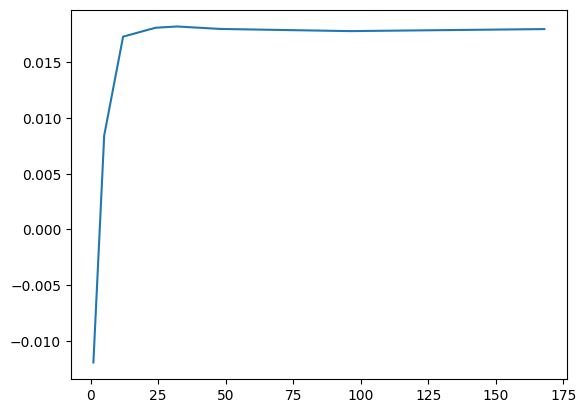

In [42]:
plt.plot(windows, qs)

In [43]:
HOLDING_WINDOW = 12

In [44]:
# Labels erstellen
labeled_data = create_labels(df_hour, window=HOLDING_WINDOW)

#dt_indicators.extend([f'EMA_{5}', f'EMA_{50}', f'EMA_{500}'])
# Liste der Indikatoren
features = dt_indicators

# Beste Indikatoren finden
best_model, best_combination, best_sharpe, train_sharpe_ratios, test_sharpe_ratios, models, combos = find_best_indicators(labeled_data, 
                                                                                                                        features, 
                                                                                                                        holding_period=HOLDING_WINDOW, 
                                                                                                                        target="label", 
                                                                                                                        signal_threshold=0.55,
                                                                                                                        plot=False)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000121, std=0.006637
Sharpe Ratio without costs: 0.01830024063528027
number of transactions 1281
mean=0.000101, std=0.006639
Sharpe Ratio with costs: 0.015217532018701688
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000089, std=0.004892
Sharpe Ratio without costs: 0.018096989805381682
number of transactions 309
mean=0.000069, std=0.004892
Sharpe Ratio with costs: 0.014067500978656809
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000271, std=0.006682
Sharpe Ratio without costs: 0.04056697570190789
number of transactions 1223
mean=0.000252, std=0.006684
Sharpe Ratio with costs: 0.03763807992168176
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000095, std=0.005027
Sharpe Ratio without costs: 0.01894962287

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000084, std=0.006198
Sharpe Ratio without costs: 0.01363182035126237
number of transactions 989
mean=0.000069, std=0.006199
Sharpe Ratio with costs: 0.011086625735813052
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000085, std=0.004374
Sharpe Ratio without costs: 0.019422559391140053
number of transactions 228
mean=0.000070, std=0.004378
Sharpe Ratio with costs: 0.016083000305386768
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000145, std=0.006463
Sharpe Ratio without costs: 0.022413323892114284
number of transactions 1401
mean=0.000123, std=0.006463
Sharpe Ratio with costs: 0.018955508834713714
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000118, std=0.004700
Sharpe Ratio without costs: 0.025200881970212703
number of transactions 342
mean=0.000097, std=0.00

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000114, std=0.006860
Sharpe Ratio without costs: 0.01663249912574106
number of transactions 1443
mean=0.000091, std=0.006862
Sharpe Ratio with costs: 0.013275698833758964
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000073, std=0.004933
Sharpe Ratio without costs: 0.01472095496028777
number of transactions 369
mean=0.000049, std=0.004937
Sharpe Ratio with costs: 0.009941911992605346
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Fitting 4 folds for ea

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000113, std=0.006355
Sharpe Ratio without costs: 0.01777600315050319
number of transactions 1661
mean=0.000086, std=0.006356
Sharpe Ratio with costs: 0.01360677670962492
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000073, std=0.004762
Sharpe Ratio without costs: 0.015349142376524252
number of transactions 418
mean=0.000046, std=0.004765
Sharpe Ratio with costs: 0.009743282873267188
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000243, std=0.006793
Sharpe Ratio without costs: 0.03570578578488314
number of transactions 1051
mean=0.000226, std=0.006795
Sharpe Ratio with costs: 0.03323062264261855
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000080, std=0.005204
Sharpe Ratio without costs: 0.015404595643141967
number of transactions 246
mean=0.000064, std=0.0052

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000263, std=0.006922
Sharpe Ratio without costs: 0.03795743450624237
number of transactions 1225
mean=0.000243, std=0.006924
Sharpe Ratio with costs: 0.035126482798557276
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000129, std=0.005081
Sharpe Ratio without costs: 0.025408358558169274
number of transactions 259
mean=0.000113, std=0.005082
Sharpe Ratio with costs: 0.02215376141025927
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000261, std=0.006586
Sharpe Ratio without costs: 0.03958978299761338
number of transactions 1153
mean=0.000242, std=0.006588
Sharpe Ratio with costs: 0.03678362980685401
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000075, std=0.004927
Sharpe Ratio without costs: 0.015209037749267948
number of transactions 233
mean=0.000060, std=0.0049

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000121, std=0.006336
Sharpe Ratio without costs: 0.01904294115369564
number of transactions 1566
mean=0.000096, std=0.006336
Sharpe Ratio with costs: 0.01510238170873769
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000096, std=0.004679
Sharpe Ratio without costs: 0.020590904899884913
number of transactions 359
mean=0.000073, std=0.004681
Sharpe Ratio with costs: 0.015690836625149404
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000187, std=0.006934
Sharpe Ratio without costs: 0.02700234570013716
number of transactions 1369
mean=0.000165, std=0.006935
Sharpe Ratio with costs: 0.023849940132418108
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000130, std=0.004845
Sharpe Ratio without costs: 0.026783326691466627
number of transactions 341
mean=0.000108, std=0.004

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000222, std=0.007059
Sharpe Ratio without costs: 0.03148077931083064
number of transactions 1171
mean=0.000204, std=0.007061
Sharpe Ratio with costs: 0.028826134527447363
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000094, std=0.005153
Sharpe Ratio without costs: 0.01827284586701359
number of transactions 253
mean=0.000078, std=0.005153
Sharpe Ratio with costs: 0.015139613681699329
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Fitting 4 folds for ea

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000133, std=0.006151
Sharpe Ratio without costs: 0.02157783171084781
number of transactions 1161
mean=0.000114, std=0.006154
Sharpe Ratio with costs: 0.018559867375310728
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000085, std=0.004488
Sharpe Ratio without costs: 0.018964501832838133
number of transactions 273
mean=0.000068, std=0.004489
Sharpe Ratio with costs: 0.015083437675746091
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000215, std=0.006922
Sharpe Ratio without costs: 0.0310374834137041
number of transactions 1141
mean=0.000197, std=0.006924
Sharpe Ratio with costs: 0.02839900027759537
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000082, std=0.005191
Sharpe Ratio without costs: 0.015852530544683475
number of transactions 241
mean=0.000067, std=0.0051

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000142, std=0.006357
Sharpe Ratio without costs: 0.02237223355611244
number of transactions 1589
mean=0.000117, std=0.006359
Sharpe Ratio with costs: 0.01838057716498909
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000075, std=0.004540
Sharpe Ratio without costs: 0.01656874581517365
number of transactions 414
mean=0.000049, std=0.004543
Sharpe Ratio with costs: 0.010744356481829788
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000320, std=0.006776
Sharpe Ratio without costs: 0.04716351104416981
number of transactions 1163
mean=0.000301, std=0.006778
Sharpe Ratio with costs: 0.04441289349900338
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000102, std=0.005131
Sharpe Ratio without costs: 0.019869258399453874
number of transactions 249
mean=0.000086, std=0.00513

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000233, std=0.006939
Sharpe Ratio without costs: 0.03362254746558868
number of transactions 1083
mean=0.000216, std=0.006940
Sharpe Ratio with costs: 0.031126714960068427
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000103, std=0.005041
Sharpe Ratio without costs: 0.020507032446323976
number of transactions 206
mean=0.000090, std=0.005042
Sharpe Ratio with costs: 0.01789793541873244
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Fitting 4 folds for ea

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000100, std=0.006966
Sharpe Ratio without costs: 0.014348629296070869
number of transactions 1402
mean=0.000078, std=0.006968
Sharpe Ratio with costs: 0.01113648551803151
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000104, std=0.004989
Sharpe Ratio without costs: 0.020912494222351224
number of transactions 329
mean=0.000083, std=0.004989
Sharpe Ratio with costs: 0.016704439336238438
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000000, std=0.000000
Sharpe Ratio without costs: nan
number of transactions 0
mean=0.000000, std=0.000000
Sharpe Ratio with costs: nan
Fitting 4 folds for e

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000373, std=0.006505
Sharpe Ratio without costs: 0.057402952095853485
number of transactions 967
mean=0.000358, std=0.006508
Sharpe Ratio with costs: 0.055008961775723585
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000136, std=0.004734
Sharpe Ratio without costs: 0.028697517859294325
number of transactions 249
mean=0.000120, std=0.004733
Sharpe Ratio with costs: 0.025345844130197772
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000265, std=0.006806
Sharpe Ratio without costs: 0.03891522430670827
number of transactions 1187
mean=0.000246, std=0.006809
Sharpe Ratio with costs: 0.036118993425022054
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000059, std=0.005066
Sharpe Ratio without costs: 0.01167789729398503
number of transactions 260
mean=0.000043, std=0.005

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000208, std=0.007123
Sharpe Ratio without costs: 0.029136474393513734
number of transactions 1273
mean=0.000187, std=0.007124
Sharpe Ratio with costs: 0.026282319790836416
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000100, std=0.005068
Sharpe Ratio without costs: 0.019770397593762704
number of transactions 292
mean=0.000082, std=0.005068
Sharpe Ratio with costs: 0.01609523701085168
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000350, std=0.006683
Sharpe Ratio without costs: 0.052443055898802333
number of transactions 1129
mean=0.000332, std=0.006685
Sharpe Ratio with costs: 0.049736733848894765
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000084, std=0.005017
Sharpe Ratio without costs: 0.016793855331960886
number of transactions 227
mean=0.000070, std=0.0

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000274, std=0.006551
Sharpe Ratio without costs: 0.041829694231231035
number of transactions 1095
mean=0.000257, std=0.006553
Sharpe Ratio with costs: 0.0391534638065985
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000060, std=0.004809
Sharpe Ratio without costs: 0.012440978491583897
number of transactions 259
mean=0.000043, std=0.004809
Sharpe Ratio with costs: 0.009008165638983667
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000259, std=0.006836
Sharpe Ratio without costs: 0.03784354750514005
number of transactions 1163
mean=0.000240, std=0.006838
Sharpe Ratio with costs: 0.035118642462445344
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000101, std=0.005189
Sharpe Ratio without costs: 0.019525354040031796
number of transactions 223
mean=0.000087, std=0.005

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000207, std=0.007037
Sharpe Ratio without costs: 0.02935268796074259
number of transactions 1157
mean=0.000188, std=0.007039
Sharpe Ratio with costs: 0.02672145341595917
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000068, std=0.005235
Sharpe Ratio without costs: 0.012985318366968304
number of transactions 273
mean=0.000051, std=0.005236
Sharpe Ratio with costs: 0.00965669235254876
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000352, std=0.006683
Sharpe Ratio without costs: 0.05263707349546038
number of transactions 1203
mean=0.000333, std=0.006685
Sharpe Ratio with costs: 0.049749277908817835
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000095, std=0.005079
Sharpe Ratio without costs: 0.01872798408597684
number of transactions 253
mean=0.000079, std=0.00508

In [47]:
res = pd.DataFrame.from_dict({"test":test_sharpe_ratios, 
                              "train":train_sharpe_ratios})
q = res["test"].quantile(0.8)

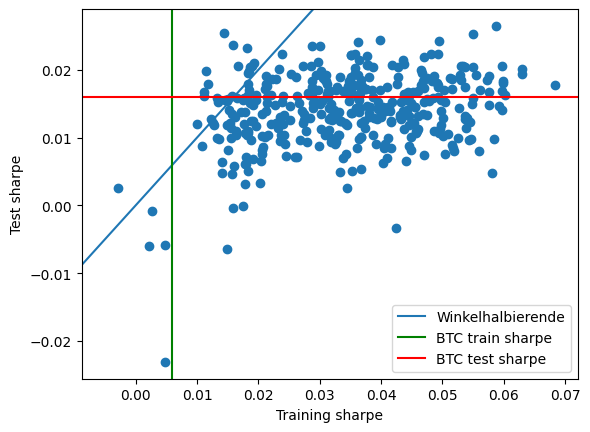

In [48]:
fig, ax = plt.subplots()

ax.scatter(train_sharpe_ratios, test_sharpe_ratios)
ax.axline((min(train_sharpe_ratios), min(train_sharpe_ratios)), slope=1, label="Winkelhalbierende")

train_btc_sharpe=0.006
test_btc_sharpe=0.016  
plt.axvline(x=train_btc_sharpe, color='g', linestyle='-', label="BTC train sharpe")
plt.axhline(y=test_btc_sharpe, color='r', linestyle='-', label="BTC test sharpe")

ax.set_xlabel("Training sharpe")
ax.set_ylabel("Test sharpe")
ax.legend()

In [50]:
# Indices which have above average training and test sharpe ratios
interesting_indices = [idx for idx, val in enumerate(test_sharpe_ratios) if val > test_btc_sharpe and train_sharpe_ratios[idx] > train_btc_sharpe]
res["model_score"] = (res["test"] - test_btc_sharpe) + (res["train"] - train_btc_sharpe)
res.iloc[interesting_indices].sort_values("model_score", ascending=True)[:20]

,test,train,model_score
10,0.016083,0.011087,0.005170
88,0.016704,0.011136,0.005841
38,0.017871,0.011762,0.007633
31,0.019806,0.011412,0.009217
79,0.016136,0.015735,0.009871
43,0.016341,0.018266,0.012607
233,0.017049,0.018429,0.013478
336,0.016251,0.019665,0.013916
4,0.017869,0.018387,0.014255
192,0.020574,0.016677,0.015251


# Select model

In [63]:
################################################
idx = 10
print(combos[idx])
THRESHOLD = 0.55
#################################################

['SMA_168_Sig', 'Momentum_168', 'SMA_720_Sig']


In [64]:
models[idx]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Beste Parameter: {}
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000084, std=0.006198
Sharpe Ratio without costs: 0.01363182035126237
number of transactions 989
mean=0.000069, std=0.006199
Sharpe Ratio with costs: 0.011086625735813052


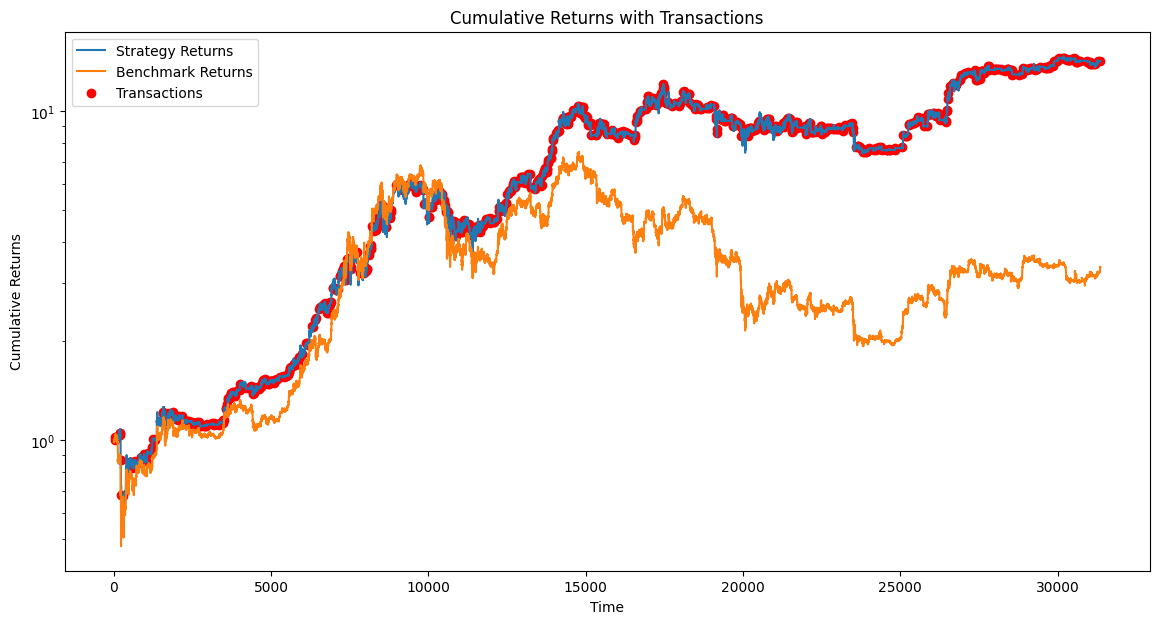

mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000085, std=0.004374
Sharpe Ratio without costs: 0.019422559391140053
number of transactions 228
mean=0.000070, std=0.004378
Sharpe Ratio with costs: 0.016083000305386768


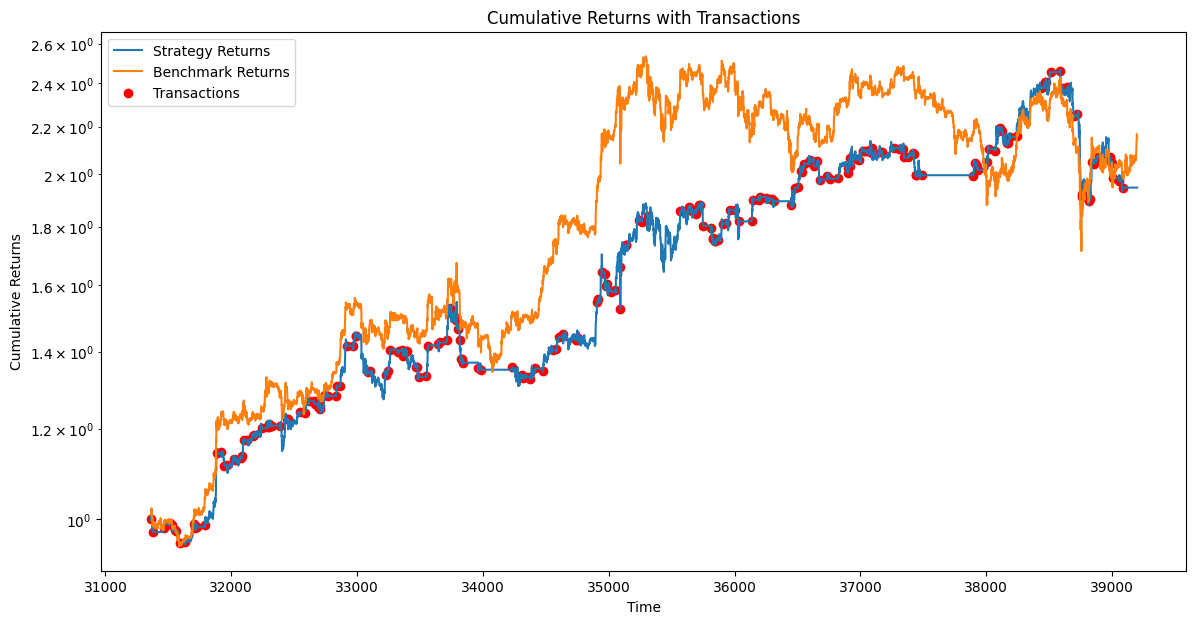

np.float64(0.016083000305386768)

In [65]:
_, X_test, X_train = train_model(data=labeled_data, features=combos[idx], target="label", param_grid={}, estimator=DecisionTreeClassifier(random_state=42))

evaluate_model(X_train, models[idx], data=labeled_data, signal_threshold=THRESHOLD, holding_period=HOLDING_WINDOW, plot=True)
evaluate_model(X_test, models[idx], data=labeled_data, signal_threshold=THRESHOLD, holding_period=HOLDING_WINDOW, plot=True)

# Single Model Analysis

In [66]:
################################# HIER 
clf = models[idx]
th = 0.55
sharpe = evaluate_model(X_train, clf, data=labeled_data, signal_threshold=th, holding_period=HOLDING_WINDOW, plot=False)
################################### HIER MODELL INDEX 

mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000084, std=0.006198
Sharpe Ratio without costs: 0.01363182035126237
number of transactions 989
mean=0.000069, std=0.006199
Sharpe Ratio with costs: 0.011086625735813052


In [67]:
sharpe = evaluate_model(X_test, clf, data=labeled_data, signal_threshold=th, holding_period=HOLDING_WINDOW, plot=False)

mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000085, std=0.004374
Sharpe Ratio without costs: 0.019422559391140053
number of transactions 228
mean=0.000070, std=0.004378
Sharpe Ratio with costs: 0.016083000305386768


In [72]:
from functools import partial

plot_func_test = partial(evaluate_model, X_test=X_test, best_clf=clf, data=labeled_data, holding_period=HOLDING_WINDOW, plot=False)
plot_func_train = partial(evaluate_model, X_test=X_train, best_clf=clf, data=labeled_data, holding_period=HOLDING_WINDOW, plot=False)
xs = np.arange(0.5, 1, 0.05)
ys_test = np.ndarray(shape=len(xs))
ys_train = np.ndarray(shape=len(xs))
for i in range(len(xs)):
     ys_test[i] = plot_func_test(signal_threshold=xs[i])
     ys_train[i] = plot_func_train(signal_threshold=xs[i])

mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000106, std=0.005294
Sharpe Ratio without costs: 0.02005254647070526
number of transactions 183
mean=0.000094, std=0.005294
Sharpe Ratio with costs: 0.017847501388240303
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000069, std=0.007285
Sharpe Ratio without costs: 0.009411246531933381
number of transactions 687
mean=0.000058, std=0.007286
Sharpe Ratio with costs: 0.007906456349341048
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471366313126
mean=0.000085, std=0.004374
Sharpe Ratio without costs: 0.019422559391140053
number of transactions 228
mean=0.000070, std=0.004378
Sharpe Ratio with costs: 0.016083000305386768
mean=0.000039, std=0.007498
Sharpe BTC 0.005149224357055185
mean=0.000084, std=0.006198
Sharpe Ratio without costs: 0.01363182035126237
number of transactions 989
mean=0.000069, std=0.006199
Sharpe Ratio with costs: 0.011086625735813052
mean=0.000098, std=0.005515
Sharpe BTC 0.017753471

C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()
C:\Users\Adria\AppData\Local\Temp\ipykernel_52240\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Text(0, 0.5, 'sharpe')

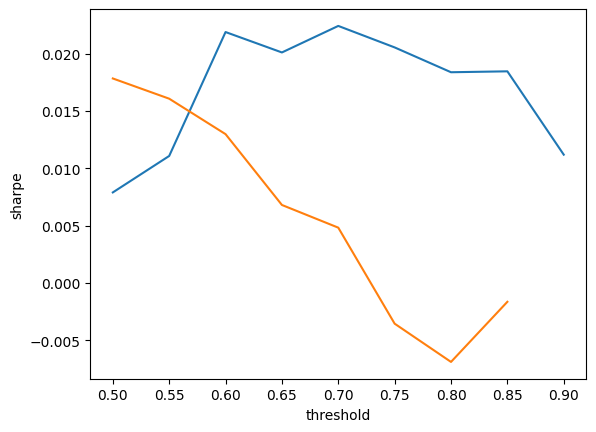

In [73]:
plt.plot(xs, ys_train)
plt.plot(xs, ys_test)
plt.xlabel("threshold")
plt.ylabel("sharpe")

In [71]:
clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [50]:
import pickle 
import base64

# Serialize an object into a plain text
def obj_to_txt(obj):
    message_bytes = pickle.dumps(obj)
    base64_bytes = base64.b64encode(message_bytes)
    txt = base64_bytes.decode('ascii')
    return txt

# De-serialize an object from a plain text
def txt_to_obj(txt):
    base64_bytes = txt.encode('ascii')
    message_bytes = base64.b64decode(base64_bytes)
    obj = pickle.loads(message_bytes)
    return obj

In [83]:
txt = obj_to_txt(clf)

obj = txt_to_obj(txt)

In [98]:
txt

'gASVLAMAAAAAAACMD3hnYm9vc3Quc2tsZWFybpSMDVhHQkNsYXNzaWZpZXKUk5QpgZR9lCiMDG5fZXN0aW1hdG9yc5ROjAlvYmplY3RpdmWUjA9iaW5hcnk6bG9naXN0aWOUjAltYXhfZGVwdGiUTowKbWF4X2xlYXZlc5ROjAdtYXhfYmlulE6MC2dyb3dfcG9saWN5lE6MDWxlYXJuaW5nX3JhdGWUTowJdmVyYm9zaXR5lE6MB2Jvb3N0ZXKUTowLdHJlZV9tZXRob2SUTowFZ2FtbWGUTowQbWluX2NoaWxkX3dlaWdodJROjA5tYXhfZGVsdGFfc3RlcJROjAlzdWJzYW1wbGWUTowPc2FtcGxpbmdfbWV0aG9klE6MEGNvbHNhbXBsZV9ieXRyZWWUTowRY29sc2FtcGxlX2J5bGV2ZWyUTowQY29sc2FtcGxlX2J5bm9kZZROjAlyZWdfYWxwaGGUTowKcmVnX2xhbWJkYZROjBBzY2FsZV9wb3Nfd2VpZ2h0lE6MCmJhc2Vfc2NvcmWUTowHbWlzc2luZ5RHf/gAAAAAAACMEW51bV9wYXJhbGxlbF90cmVllE6MDHJhbmRvbV9zdGF0ZZRLKowGbl9qb2JzlE6MFG1vbm90b25lX2NvbnN0cmFpbnRzlE6MF2ludGVyYWN0aW9uX2NvbnN0cmFpbnRzlE6MD2ltcG9ydGFuY2VfdHlwZZROjAZkZXZpY2WUTowTdmFsaWRhdGVfcGFyYW1ldGVyc5ROjBJlbmFibGVfY2F0ZWdvcmljYWyUiYwNZmVhdHVyZV90eXBlc5ROjBFtYXhfY2F0X3RvX29uZWhvdJROjBFtYXhfY2F0X3RocmVzaG9sZJROjA5tdWx0aV9zdHJhdGVneZROjAtldmFsX21ldHJpY5ROjBVlYXJseV9zdG9wcGluZ19yb3VuZHOUTowJY2FsbGJhY2tzlE6MCm5fY2xhc3Nlc1+USwKMCF9

mean=0.000098, std=0.005495
Sharpe BTC 0.017828314946919967
mean=0.000130, std=0.004607
Sharpe Ratio without costs: 0.02828174056517683
number of transactions 21
mean=0.000129, std=0.004607
Sharpe Ratio with costs: 0.027989779222297843
mean=0.000098, std=0.005495
Sharpe BTC 0.017828314946919967
mean=0.000124, std=0.003684
Sharpe Ratio without costs: 0.03369529196423988
number of transactions 21
mean=0.000123, std=0.003685
Sharpe Ratio with costs: 0.03331923701757554
mean=0.000098, std=0.005495
Sharpe BTC 0.017828314946919967
mean=0.000085, std=0.003113
Sharpe Ratio without costs: 0.027177318753089662
number of transactions 19
mean=0.000083, std=0.003114
Sharpe Ratio with costs: 0.026774245052758765
mean=0.000098, std=0.005495
Sharpe BTC 0.017828314946919967
mean=0.000083, std=0.003098
Sharpe Ratio without costs: 0.02678631994003383
number of transactions 21
mean=0.000082, std=0.003099
Sharpe Ratio with costs: 0.026342804430834393
mean=0.000098, std=0.005495
Sharpe BTC 0.017828314946919

C:\Users\Adria\AppData\Local\Temp\ipykernel_21404\290061237.py:3: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = s.mean() / s.std()


Text(0, 0.5, 'sharpe')

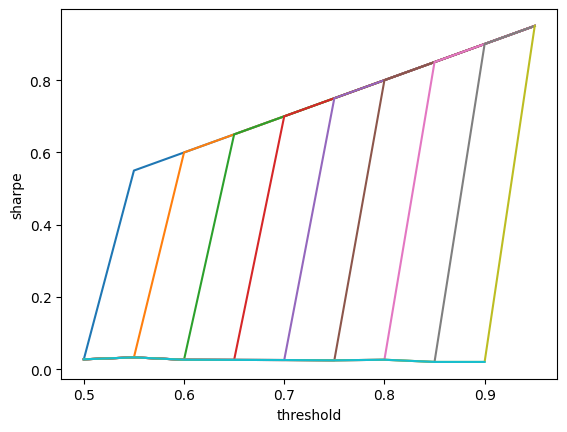

In [54]:
plot_func = partial(evaluate_model, X_test=X_test, best_clf=obj, data=labeled_data, holding_period=HOLDING_WINDOW, plot=False)
xs = np.arange(0.5, 1, 0.05)
ys = np.ndarray(shape=len(xs))
for i in range(len(xs)):
     ys[i] = plot_func(signal_threshold=xs[i])
     plt.plot(xs, ys)
plt.xlabel("threshold")
plt.ylabel("sharpe")